## IkbSR experiments
1/26/26 - Data generated from KP Rosa26-RIK/+ mice infected with doxycycline inducible IkbSR-Cre construct vs a Cre construct control; Doxycycline was induced for 1 week at 16 weeks post tumor induction (PTI) and tumors were harvested at 17 weeks PTI. data submitted by Jason/Carleigh/CHP/Emma/Eliud/Hannah on 6/22/23

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","shRenilla",'JCP628-shIkbkg-1.2526','JCP629-shIkbkg-2.2984',
           'JCP618-shRela-1.1202','JCP621-shRela-4.1182','JCP623-shRel-1.1868',
           'JCP625-shRel-3.342','Ikbsr-FLAG',]

## Load adata object

In [6]:
adata = anndata.read_h5ad('write/Nfkb_combined.h5ad')

In [7]:
adata.obs['Group'].value_counts()

Group
Cre             6186
shRenilla       5386
IkbSR-Cre       4053
shNfkb1_2331    2364
shRela           923
shRel            640
shNfkb1          398
shNfkb1_3737     377
Name: count, dtype: int64

In [8]:
# select experimental lanes
adata = adata[adata.obs.batch.isin(['Cre','IkbSR-Cre']),:]
# reorder categories
adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['Cre','IkbSR-Cre'])

/tmp/ipykernel_48357/4126608151.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['Cre','IkbSR-Cre'])


In [9]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = 2

In [10]:
adata.obs[['batch','condition','Classification']].value_counts(sort=False)

batch      condition  Classification
IkbSR-Cre  control    AY1264_B0301      1511
                      AY1267_B0302       555
                      AY1268_B0303      1035
                      AY1271_B0305      1530
                      AY1422_B0304      1555
           perturb    AY1262_B0306       136
                      AY1263_B0307       425
                      AY1425_B0308       990
                      AY1483_B0309      1253
                      AY1484_B0310      1249
Name: count, dtype: int64

## Evaluate Nfkb1 knockdown and associated genes

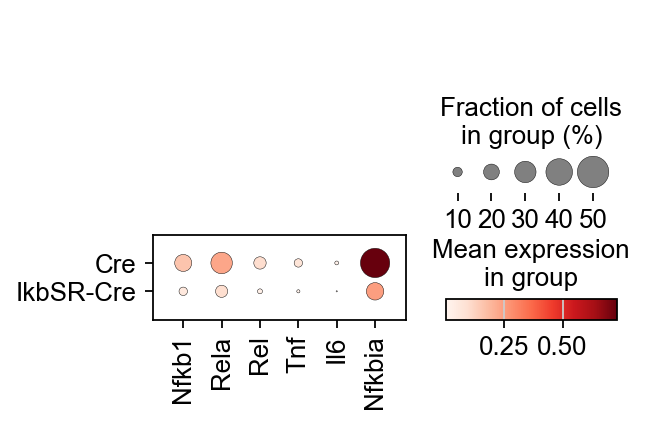

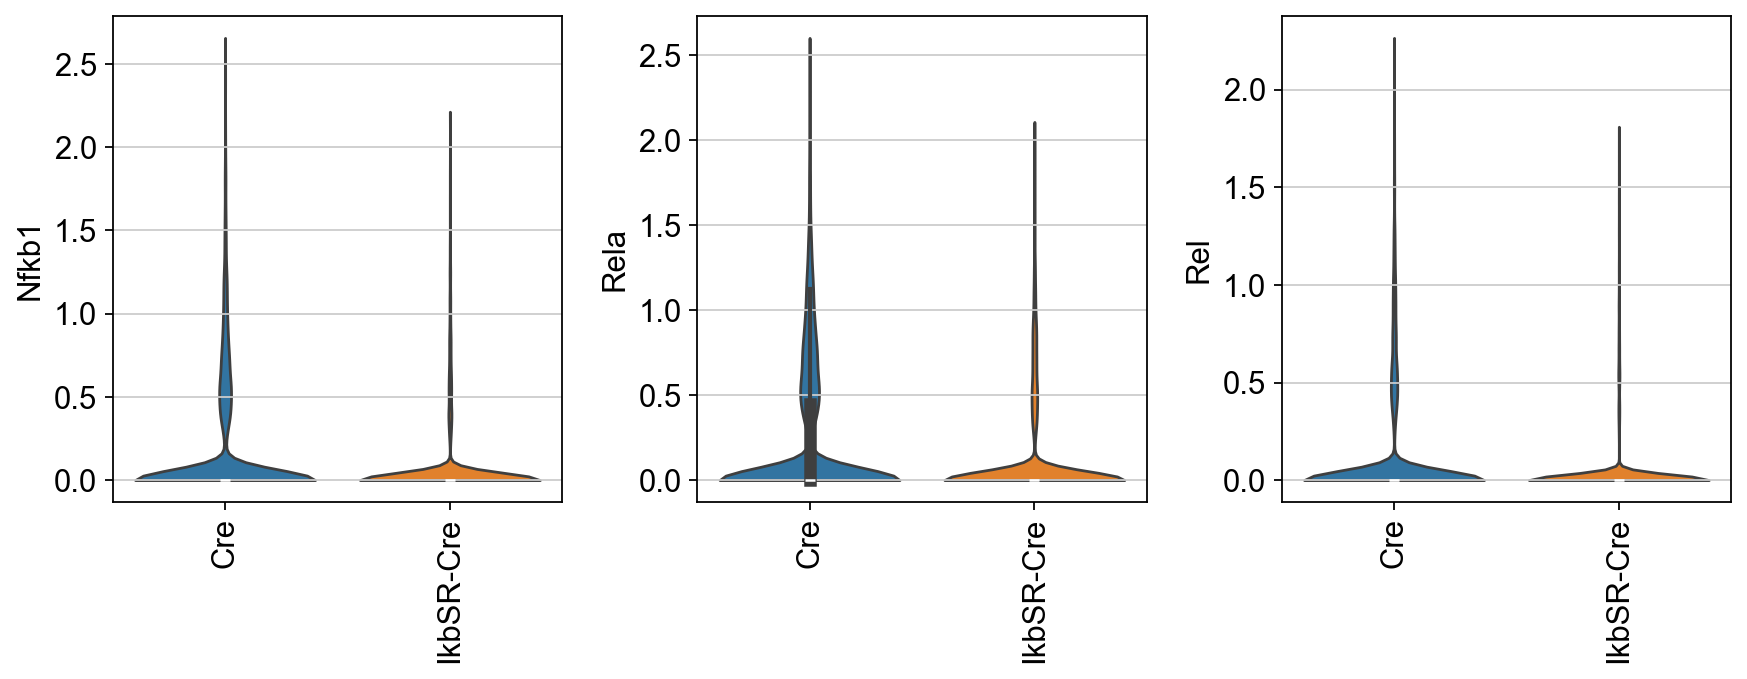

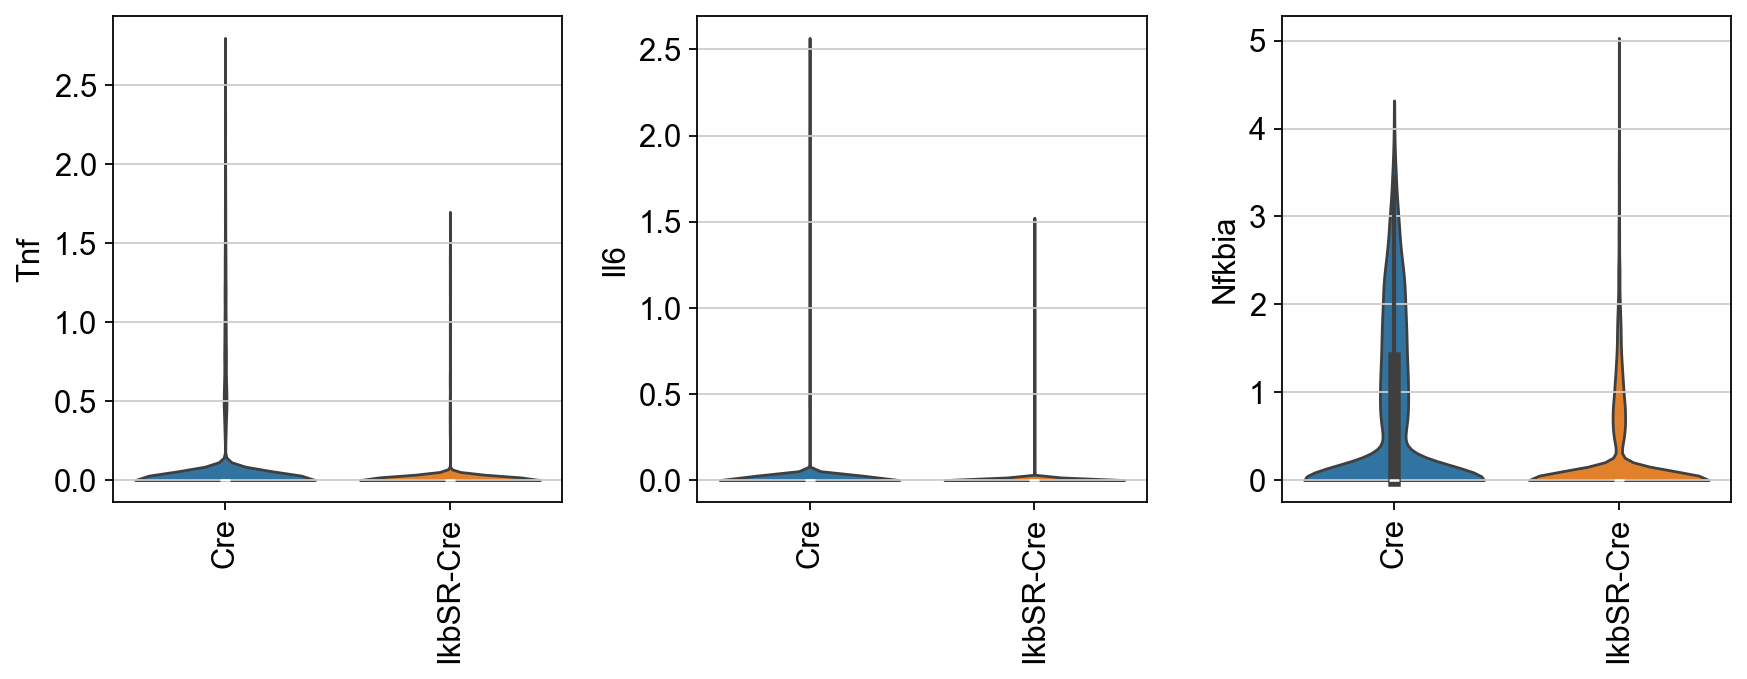

In [11]:
# note p50 (encoded by Nfkb1) creates repressive homodimers and also is an activator with p65, so there might be mixed signal; expect Tnf and Il6 to go down
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group', use_raw=True)
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)


## Now select cells by Cre expression

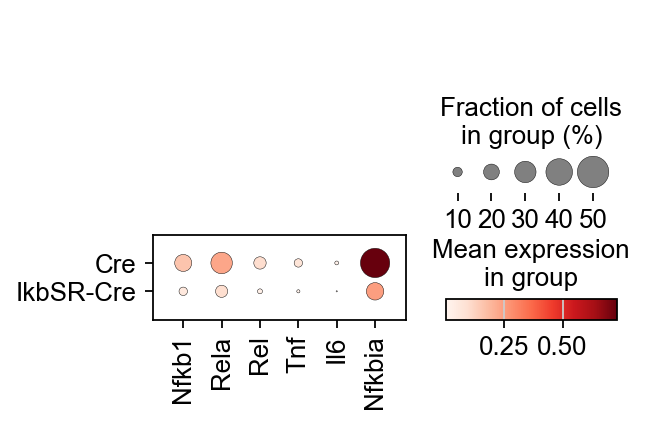

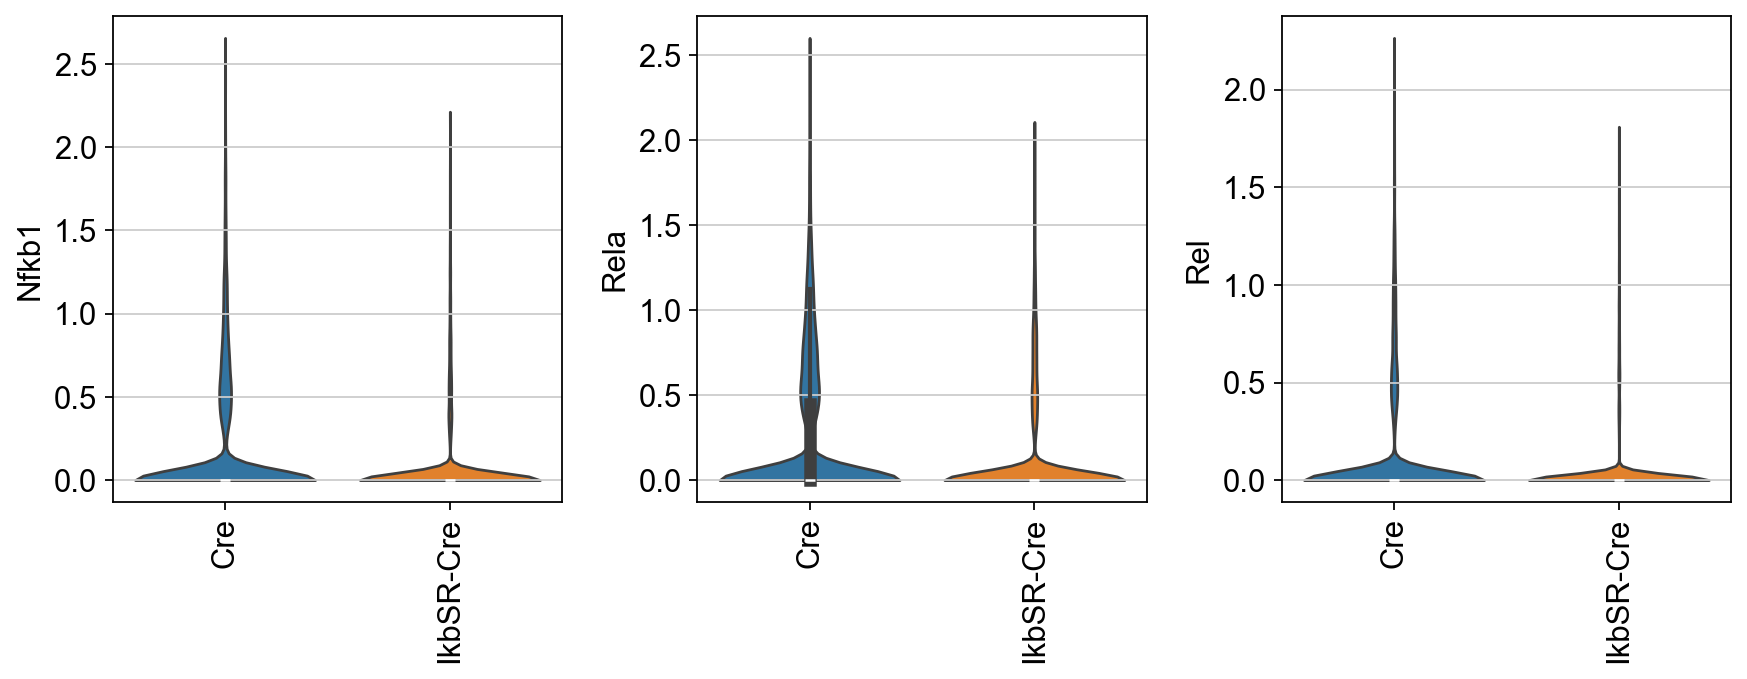

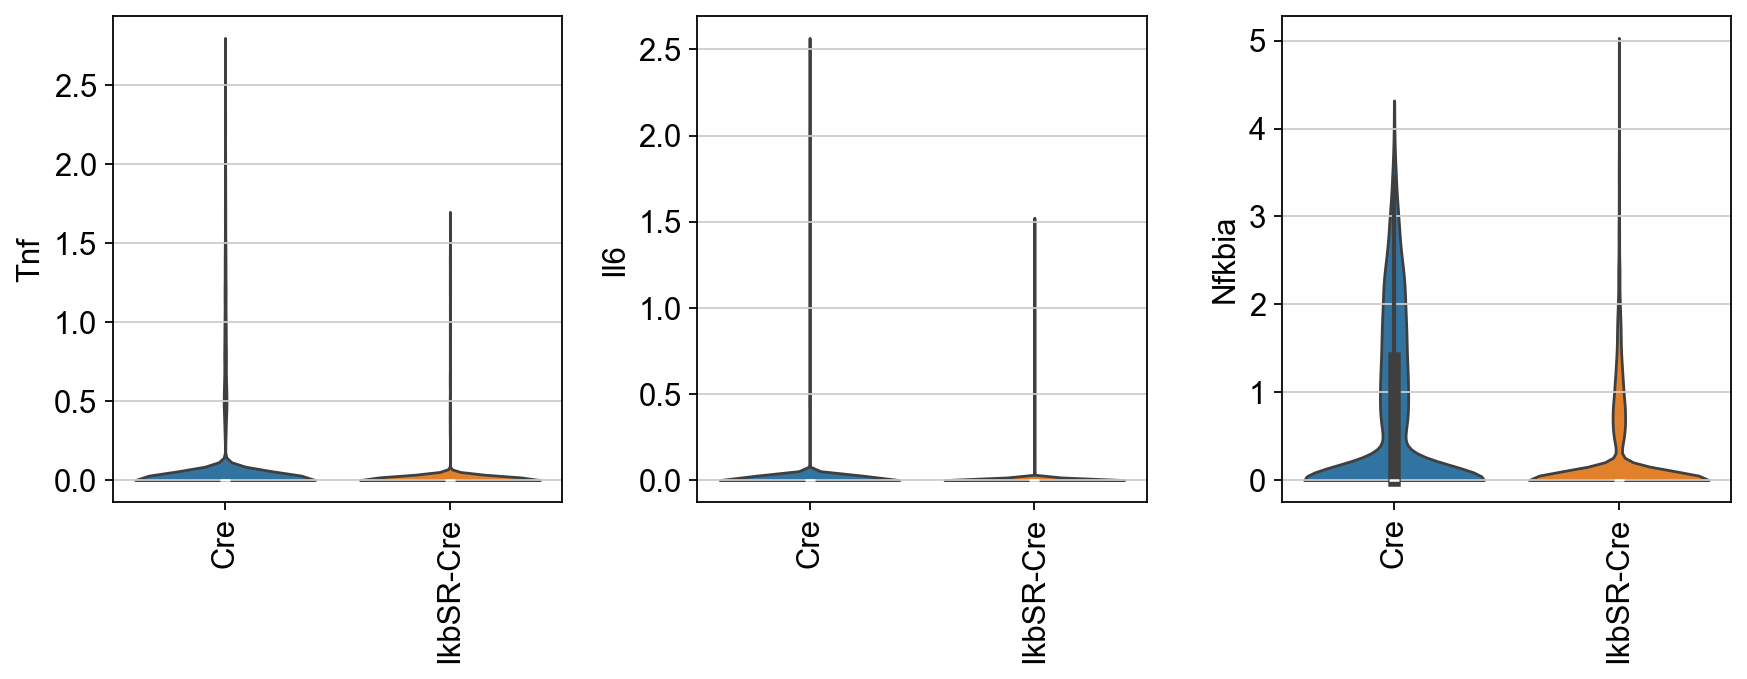

In [12]:
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group')
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False)


In [13]:
import csv
# Define NFκB target gene signatures
nfkb_targets_broad = ['Birc3', 'Bcl2a1a', 'Bcl2a1b', 'Bcl2a1c', 'Bcl2a1d',
                      'Cflar', 'Traf1', 'Ccl5', 'Cxcl1', 'Cxcl2', 
                      'Cxcl10', 'Il1b', 'Ccl3', 'Ccl4']

# Note: Mouse doesn't have CXCL8 (IL-8), but has functional homologs
# Remove Cxcl8 if not in your data, or replace with Cxcl1/Cxcl2
nfkb_targets_classical = ['Tnf', 'Il6', 'Ccl2', 'Icam1', 
                          'Vcam1', 'Nfkbia', 'Nfkbiz', 'Tnfaip3',
                          'Cxcl1', 'Cxcl2']  # Added mouse chemokines

nfkb_genes = [
    "Ager","Alox12b","Apoc3","B2m","Bcl2","Bcl2a1","Bcl2l1","Bcl3","Bdkrb1",
    "Ccl11","Ccl15","Ccl2","Ccl5","Ccnd1","Ccr5","Ccr7","Cd209","Cd3g","Cd40",
    "Cd40lg","Cd44","Cd48","Cd69","Cd74","Cd80","Cd83","Cr2","Crp","Csf1",
    "Csf2","Csf3","Cxcl5","Cxcl8","Cxcr5","Defb4","Elf3","Eng","F3","Fas",
    "Faslg","Gstp1","Hmox1","Icam1","Ier3","Ifnb1","Ighg3","Ighg4","Il11",
    "Il13","Il15","Il15ra","Il1a","Il1b","Il1rn","Il2","Il2ra","Il6","Il9",
    "Irf1","Irf2","Irf4","Irf7","Klk3","Lta","Ltb","Mmp9","Myc","Nfkb1",
    "Nfkb2","Nfkbia","Nod2","Nos2","Nqo1","Nr4a2","Oprm1","Pdgfb","Plau",
    "Plcd1","Psma2","Psmb9","Ptafr","Ptgs2","Ptx3","Relb","S100a6","Scnn1a",
    "Sele","Selp","Slc2a5","Sod2","Stat5a","Tacr1","Tap1","Tfpi2","Tgm2",
    "Tnc","Tnf","Tnfaip3","Tnfrsf9","Tp53","Tpmt","Vcam1","Vegfc","Vim"
]

# Additional important mouse NFκB targets
nfkb_targets_extended = ['Ptgs2', 'Nos2', 'Sod2', 'Csf2', 'Csf3',
                         'Il1a', 'Il1b', 'Ccl20', 'Cxcl10', 'Relb']

# Define p50 targets that are normally repressed by p50 homodimers (encoded by Nfkb1):
p50_targets = ['Ccl2', 'Cxcl10', 'Csf2', 'Mmp13', 'Il6', 'Il1b', 'Nos2', 'Lcn2', 'Batf']

# Hallmark Nfkb genes from mSigDB:
hallmark_nfkb = []
with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                hallmark_nfkb = [x for row in csvreader for x in row]
    
# Score each cell
sc.tl.score_genes(adata, 
                  gene_list=nfkb_targets_classical,
                  score_name='nfkb_classical_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_broad, 
                  score_name='nfkb_broad_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_extended, 
                  score_name='nfkb_extended_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_genes, 
                  score_name='nfkb_genes_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=p50_targets, 
                  score_name='p50_targets',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=hallmark_nfkb, 
                  score_name='hallmark_nfkb',
                  use_raw=True)

computing score 'nfkb_classical_score'
    finished: added
    'nfkb_classical_score', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)
computing score 'nfkb_broad_score'
    finished: added
    'nfkb_broad_score', score of gene set (adata.obs).
    499 total control genes are used. (0:00:00)
computing score 'nfkb_extended_score'
    finished: added
    'nfkb_extended_score', score of gene set (adata.obs).
    450 total control genes are used. (0:00:00)
computing score 'nfkb_genes_score'
       'Faslg', 'Ighg4', 'Il9', 'Klk3', 'Tp53'],
      dtype='object')
    finished: added
    'nfkb_genes_score', score of gene set (adata.obs).
    995 total control genes are used. (0:00:00)
computing score 'p50_targets'
    finished: added
    'p50_targets', score of gene set (adata.obs).
    350 total control genes are used. (0:00:00)
computing score 'hallmark_nfkb'
    finished: added
    'hallmark_nfkb', score of gene set (adata.obs).
    990 total control genes are

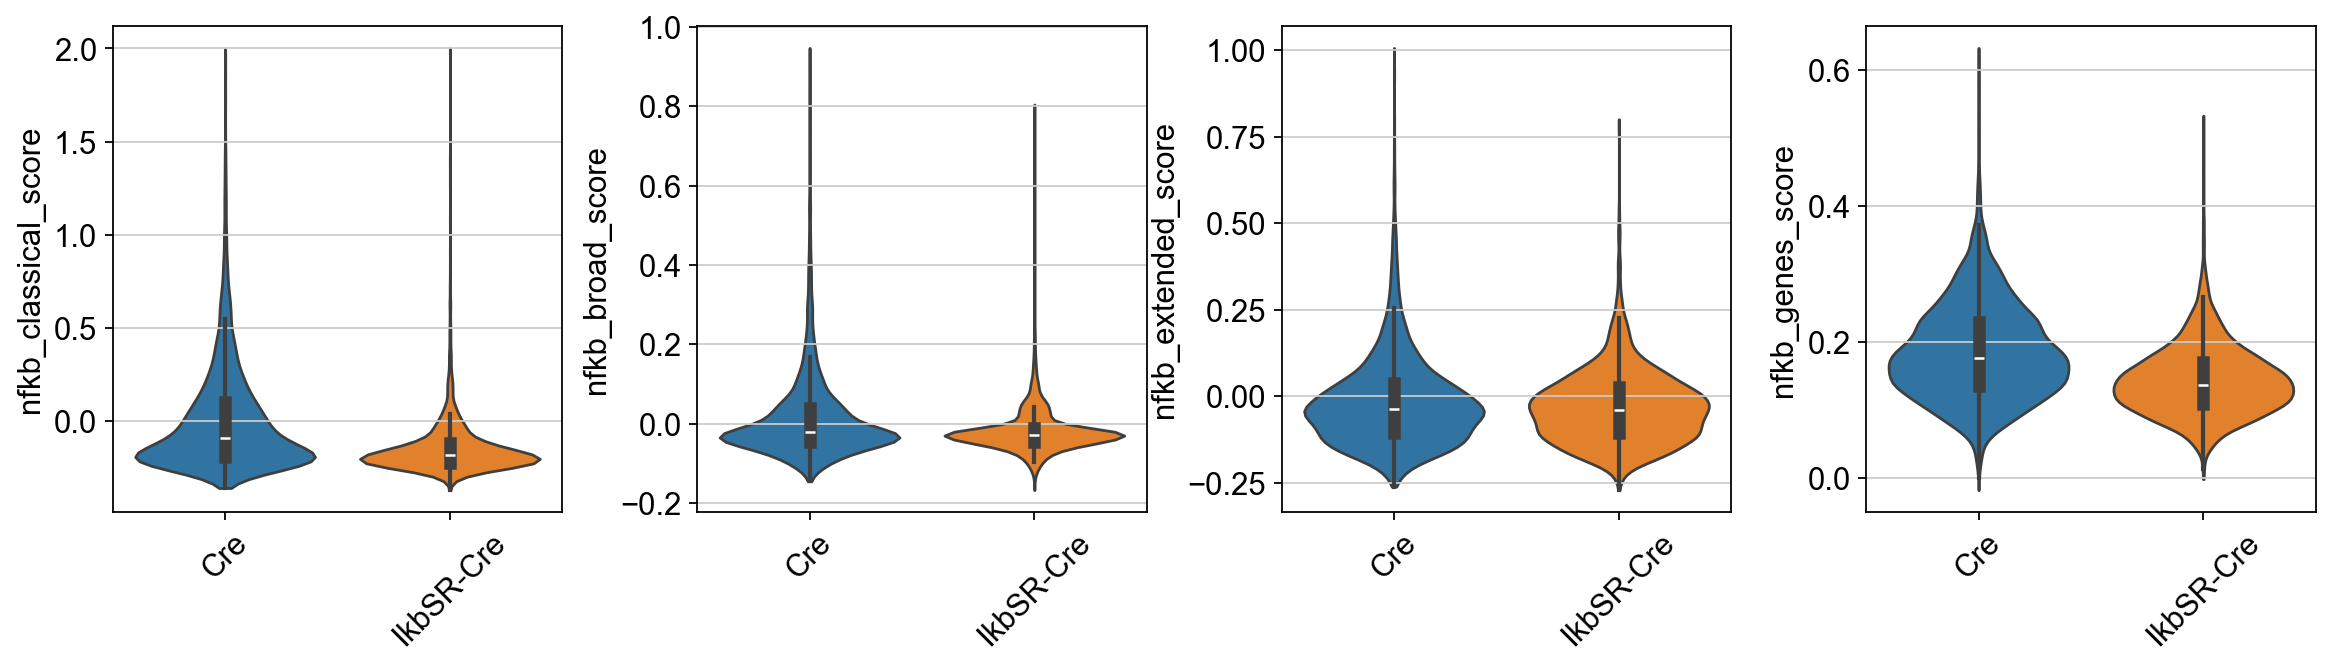

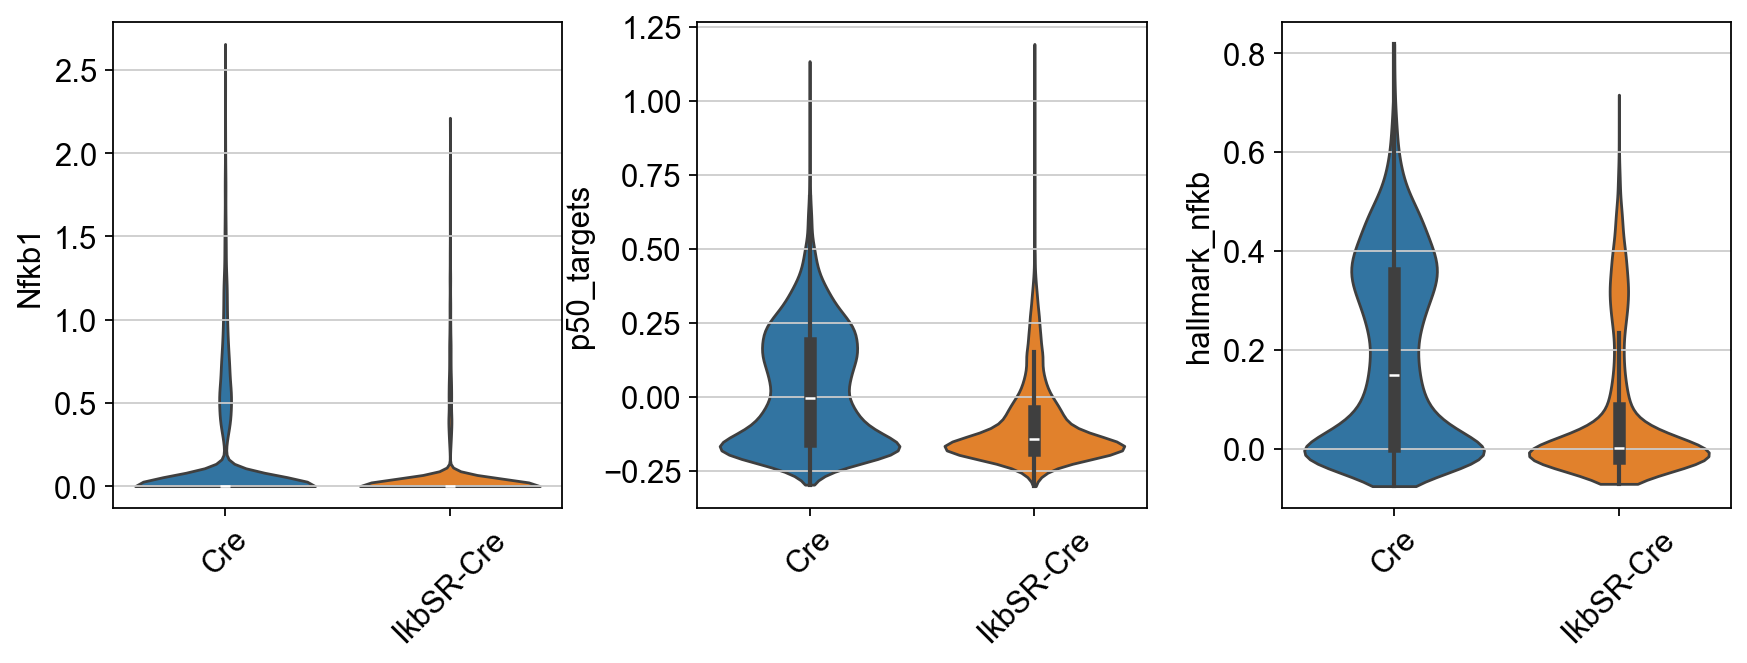

In [14]:
sc.pl.violin(adata, 
             keys=['nfkb_classical_score', 'nfkb_broad_score', 'nfkb_extended_score', 'nfkb_genes_score'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)
sc.pl.violin(adata, 
             keys=['Nfkb1','p50_targets','hallmark_nfkb'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)

In [15]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='Cre'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='IkbSR-Cre'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0000


In [16]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='Cre'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='IkbSR-Cre'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP2 classical score: p={pval:.4f}")

shRenilla vs HP2 classical score: p=0.0002


In [17]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata,
    groupby="Group",                 # Cre / IkbSR-Cre
    groups=["IkbSR-Cre"],
    reference="Cre",
    method="wilcoxon",
    use_raw=True
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


In [18]:
df = sc.get.rank_genes_groups_df(adata, group="IkbSR-Cre")


In [19]:
import pandas as pd

df = adata.obs.copy()
df["Nfkb1_expr"] = (
    adata.raw[:, "Nfkb1"].X.A1
    if hasattr(adata.raw[:, "Nfkb1"].X, "A1")
    else adata.raw[:, "Nfkb1"].X.toarray().ravel()
)

pb = (
    df.groupby(["Classification", "Group"])["Nfkb1_expr"]
      .mean()
      .reset_index()
)

/tmp/ipykernel_48357/1904172550.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Nfkb1_expr"]


Text(0, 0.5, 'Mean Nfkb1 expression per mouse')

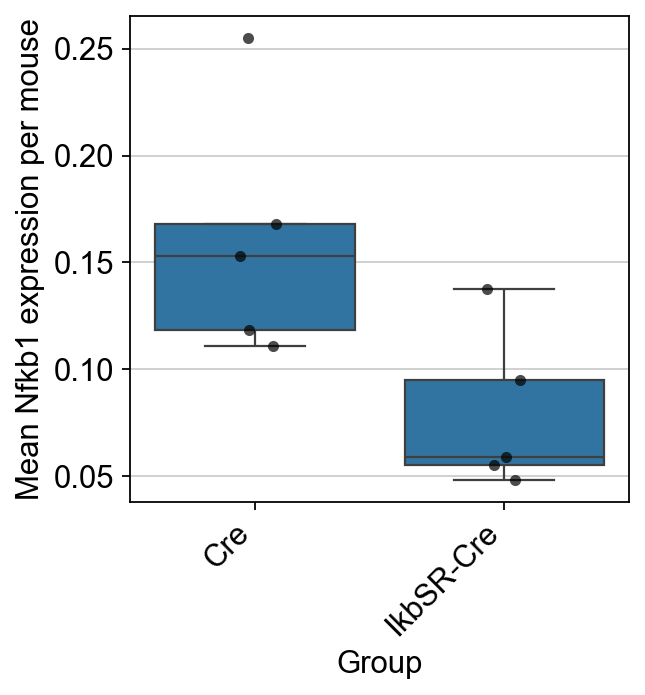

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    showfliers=False,
)
sns.stripplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Nfkb1 expression per mouse")



Rows (mouse × group): 10

Mice per group:
 Group
IkbSR-Cre    5
Cre          5
Name: count, dtype: int64

Cells per mouse×group summary:
            count    mean         std    min     25%     50%     75%     max
Group                                                                      
Cre          5.0  1237.2  438.171428  555.0  1035.0  1511.0  1530.0  1555.0
IkbSR-Cre    5.0   810.6  505.932110  136.0   425.0   990.0  1249.0  1253.0


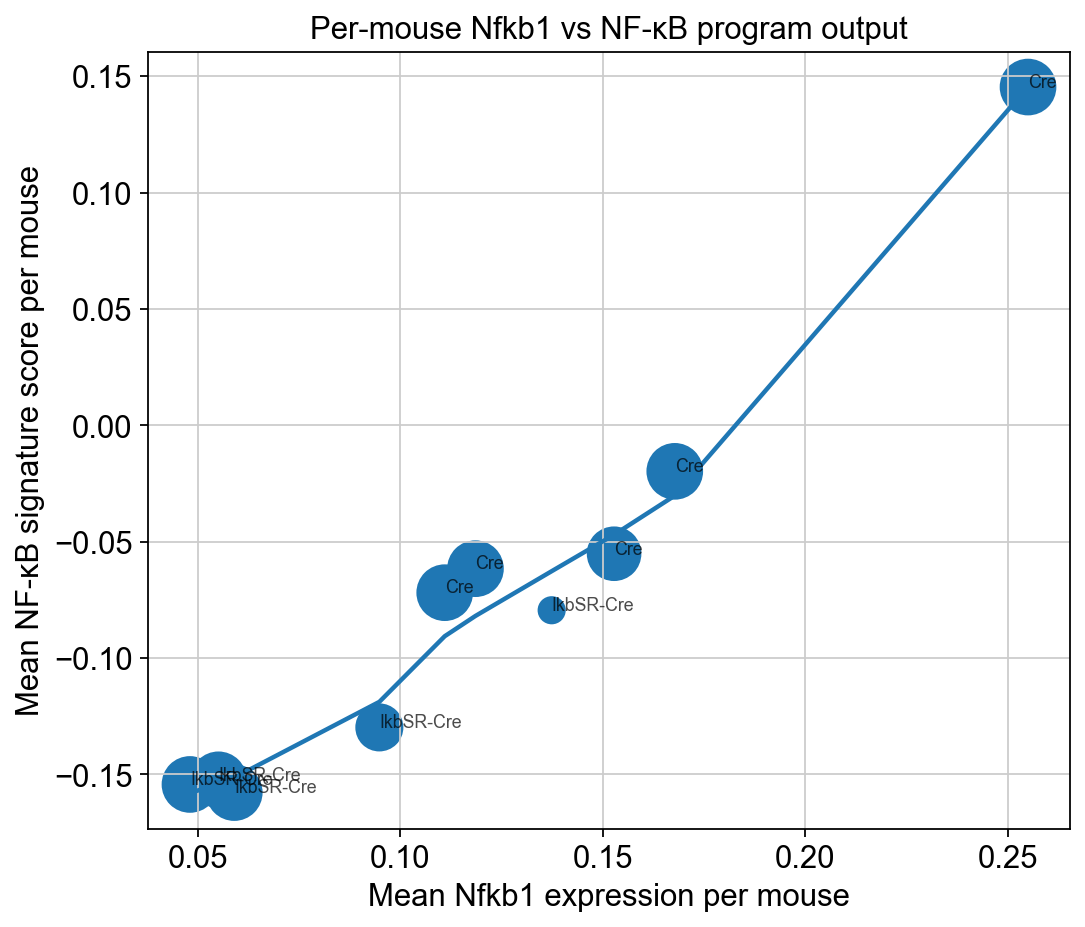

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# -----------------------------
# USER SETTINGS (edit these)
# -----------------------------
MOUSE_COL   = "Classification"
GROUP_COL   = "Group"          # shRenilla / Nfkb1_2331 / Nfkb1_3737
GENE        = "Nfkb1"
SCORE_COL   = "nfkb_classical_score"       # must already exist in adata.obs, OR compute below
COUNTS_LAYER_FOR_SCORE = None    # leave None unless you want to force use_raw/layer logic

# Optional: subset to a celltype (recommended if mixed)
CELLTYPE_COL = None   # e.g., "celltype"
KEEP_CELLTYPE = None  # e.g., "Tumor"

# Optional: compute the NF-κB score here (replace gene list!)
COMPUTE_SCORE = False
NFkB_GENESET = ["Nfkbia", "Tnfaip3", "Rel", "Relb", "Icam1", "Cxcl1", "Cxcl2", "Il1b"]


# -----------------------------
# (Optional) subset cells
# -----------------------------
adata_use = adata
if CELLTYPE_COL is not None and KEEP_CELLTYPE is not None:
    adata_use = adata[adata.obs[CELLTYPE_COL].astype(str) == str(KEEP_CELLTYPE)].copy()
    print(f"Using subset: {adata_use.n_obs} cells where {CELLTYPE_COL} == {KEEP_CELLTYPE}")

# -----------------------------
# (Optional) compute signature score
# -----------------------------
if COMPUTE_SCORE:
    import scanpy as sc
    genes_present = [g for g in NFkB_GENESET if g in adata_use.var_names]
    if len(genes_present) < 5:
        raise ValueError(f"Too few NF-κB genes found in adata.var_names: {genes_present}")
    sc.tl.score_genes(adata_use, gene_list=genes_present, score_name=SCORE_COL, use_raw=False)
    print(f"Computed {SCORE_COL} using {len(genes_present)} genes.")

if SCORE_COL not in adata_use.obs.columns:
    raise ValueError(
        f"Missing adata.obs['{SCORE_COL}']. Set COMPUTE_SCORE=True or provide your precomputed score."
    )

# -----------------------------
# Extract per-cell Nfkb1 expression
# -----------------------------
if GENE not in adata_use.var_names:
    # case-insensitive fallback
    lower_map = {g.lower(): g for g in adata_use.var_names}
    if GENE.lower() in lower_map:
        print(f"NOTE: '{GENE}' not found exactly; using '{lower_map[GENE.lower()]}' instead.")
        GENE = lower_map[GENE.lower()]
    else:
        raise ValueError(f"Gene '{GENE}' not found in adata.var_names.")

Xg = adata_use.raw[:, GENE].X
if sp.issparse(Xg):
    nfkb1_expr = Xg.toarray().ravel()
else:
    nfkb1_expr = np.asarray(Xg).ravel()

# -----------------------------
# Build per-cell dataframe
# -----------------------------
for col in [MOUSE_COL, GROUP_COL]:
    if col not in adata_use.obs.columns:
        raise ValueError(f"Missing adata.obs['{col}'].")

df = adata_use.obs[[MOUSE_COL, GROUP_COL]].copy()
df[MOUSE_COL] = df[MOUSE_COL].astype(str)
df[GROUP_COL] = df[GROUP_COL].astype(str)
df["nfkb1_expr"] = nfkb1_expr
df[SCORE_COL] = adata_use.obs[SCORE_COL].values

# -----------------------------
# Aggregate per mouse (and group)
# -----------------------------
pb = (df.groupby([MOUSE_COL, GROUP_COL])
        .agg(
            nfkb1_mean=("nfkb1_expr", "mean"),
            nfkb_score_mean=(SCORE_COL, "mean"),
            n_cells=("nfkb1_expr", "size"),
        )
        .reset_index())

print("\nRows (mouse × group):", pb.shape[0])
print("\nMice per group:\n", pb[GROUP_COL].value_counts())
print("\nCells per mouse×group summary:\n", pb.groupby(GROUP_COL)["n_cells"].describe())

# -----------------------------
# Plot: x = mean Nfkb1 per mouse, y = mean NF-κB score per mouse
# Point size encodes n_cells (optional), and we label by group.
# -----------------------------
plt.figure(figsize=(7, 6))

sizes = np.clip(pb["n_cells"].values, 50, 600)  # optional sizing by cells
plt.scatter(pb["nfkb1_mean"], pb["nfkb_score_mean"], s=sizes)

# annotate each point with perturb label (can be noisy if many mice)
for _, r in pb.iterrows():
    plt.text(r["nfkb1_mean"], r["nfkb_score_mean"], r[GROUP_COL], fontsize=8, alpha=0.7)

plt.xlabel("Mean Nfkb1 expression per mouse")
plt.ylabel("Mean NF-κB signature score per mouse")
plt.title("Per-mouse Nfkb1 vs NF-κB program output")

# Add a smoother to reveal nonlinearity (LOWESS if available; else quadratic fit)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna().sort_values("nfkb1_mean")
    sm = lowess(xy["nfkb_score_mean"], xy["nfkb1_mean"], frac=0.6, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], linewidth=2)
except Exception:
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna()
    if len(xy) >= 5:
        xs = np.linspace(xy["nfkb1_mean"].min(), xy["nfkb1_mean"].max(), 200)
        coeff = np.polyfit(xy["nfkb1_mean"], xy["nfkb_score_mean"], deg=2)
        plt.plot(xs, np.polyval(coeff, xs), linewidth=2)

plt.tight_layout()
plt.show()


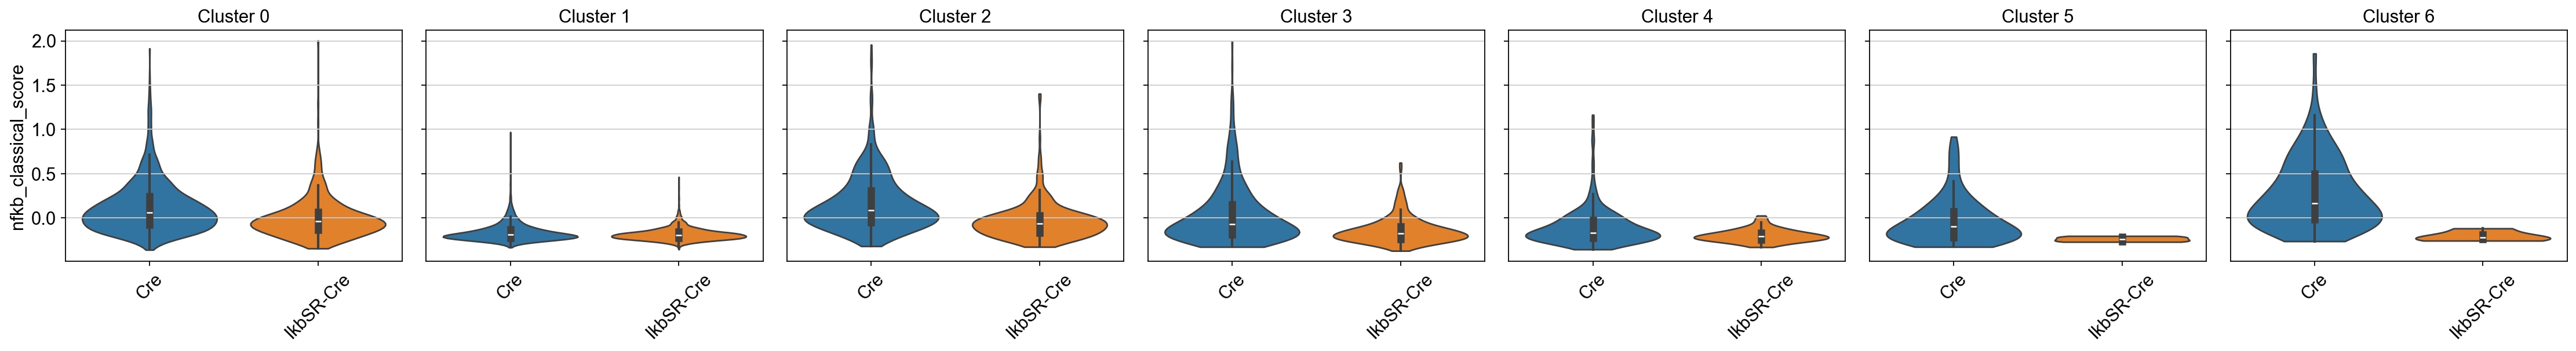

In [22]:
import matplotlib.pyplot as plt

# Get unique clusters
clusters = sorted(adata.obs['leiden'].unique())

# Create subplots
fig, axes = plt.subplots(1, len(clusters), figsize=(4*len(clusters), 4), sharey=True)
if len(clusters) == 1:
    axes = [axes]

for ax, cluster in zip(axes, clusters):
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    sc.pl.violin(adata_cluster,
                 keys='nfkb_classical_score',
                 groupby='Group',
                 ax=ax,
                 show=False, rotation=45, stripplot=False, inner='box')
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

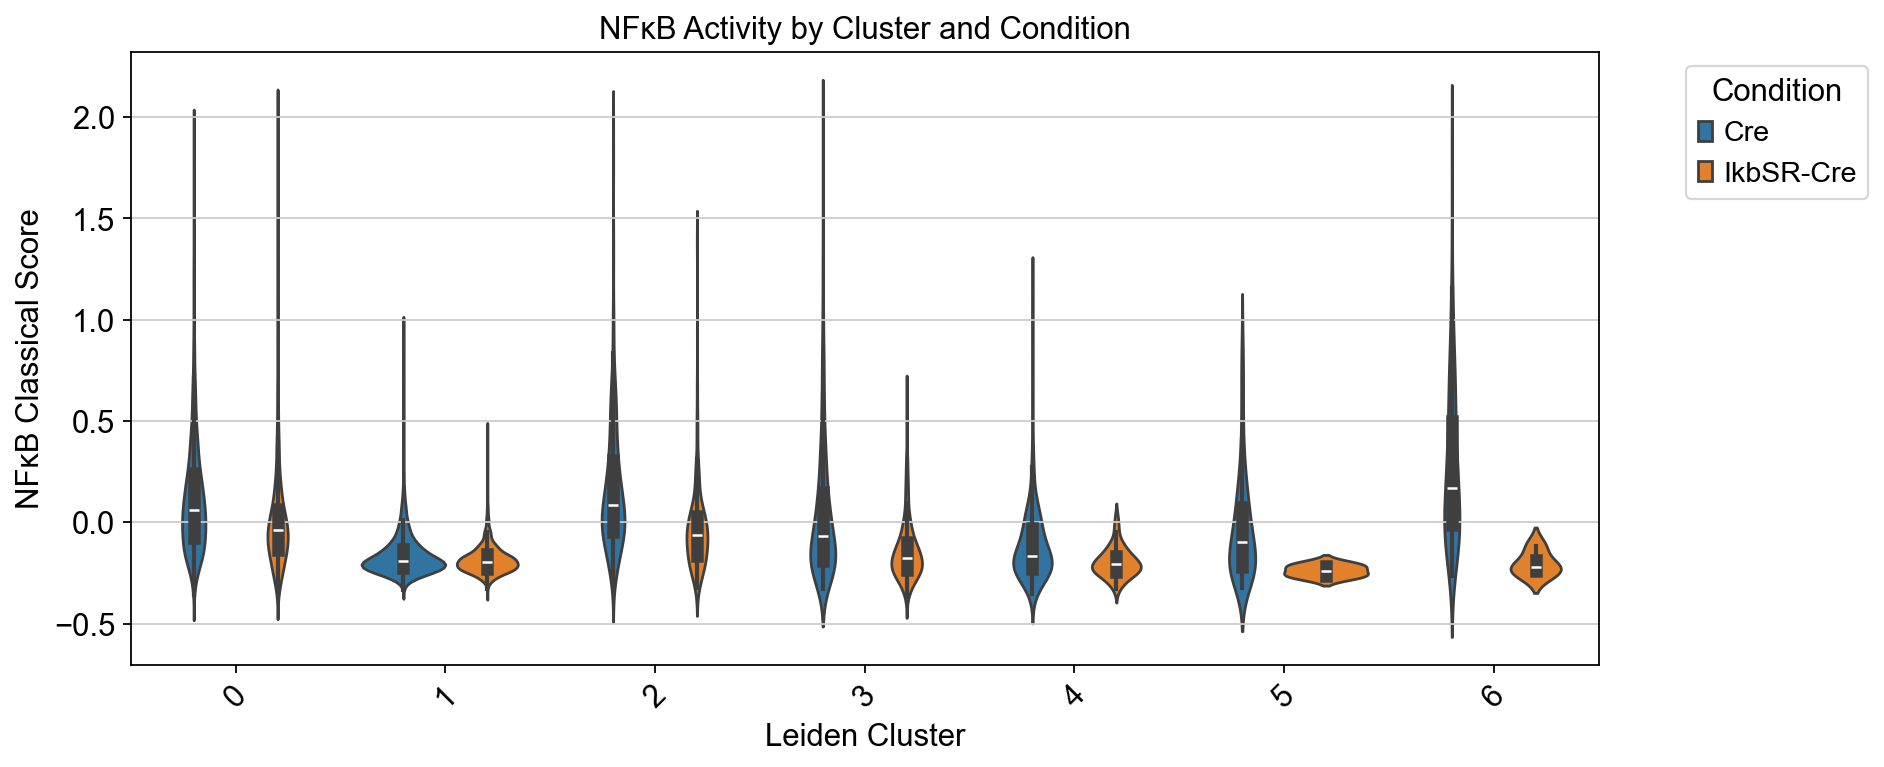

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
plot_data = adata.obs[['leiden', 'Group', 'nfkb_classical_score']].copy()

# Create the plot
plt.figure(figsize=(12, 5))
sns.violinplot(data=plot_data,
               x='leiden',
               y='nfkb_classical_score',
               hue='Group',
               split=False,  # Set to True if you want split violins
               inner='box')
plt.xticks(rotation=45)
plt.xlabel('Leiden Cluster')
plt.ylabel('NFκB Classical Score')
plt.title('NFκB Activity by Cluster and Condition')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Compare HP1 vs HP2 within each cluster
cluster_comparisons = []

for cluster in adata.obs['leiden'].unique():
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    # Get scores for each group
    ctrl_scores = adata_cluster[adata_cluster.obs['Group']=='Cre'].obs['nfkb_classical_score']
    hp1_scores = adata_cluster[adata_cluster.obs['Group']=='IkbSR-Cre'].obs['nfkb_classical_score']
    
    # Statistical tests
    if len(hp1_scores) > 0 and len(ctrl_scores) > 0:
        _, pval_hp1 = mannwhitneyu(hp1_scores, ctrl_scores)
    else:
        pval_hp1 = None
    
    cluster_comparisons.append({
        'cluster': cluster,
        'n_ctrl': len(ctrl_scores),
        'n_hp1': len(hp1_scores),
        'mean_ctrl': ctrl_scores.mean() if len(ctrl_scores) > 0 else None,
        'mean_hp1': hp1_scores.mean() if len(hp1_scores) > 0 else None,
        'pval_hp1_vs_ctrl': pval_hp1,
    })

comparison_df = pd.DataFrame(cluster_comparisons)
print(comparison_df.to_string())

  cluster  n_ctrl  n_hp1  mean_ctrl  mean_hp1  pval_hp1_vs_ctrl
0       4     230     48  -0.099924 -0.197669      8.598669e-04
1       1    2432   2991  -0.161886 -0.184294      7.735790e-09
2       0    2164    478   0.120450 -0.002505      1.499871e-23
3       6     118      4   0.271971 -0.203918      2.215545e-04
4       3     563    224   0.034947 -0.140792      6.019675e-15
5       2     585    303   0.159482 -0.034417      8.429793e-28
6       5      94      5  -0.030838 -0.238366      1.659287e-02


Group
Cre          6186
IkbSR-Cre    4053
Name: count, dtype: int64
computing score 'prolif_score'
    finished: added
    'prolif_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'apoptosis_score'
    finished: added
    'apoptosis_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)
computing score 'repressor_score'
    finished: added
    'repressor_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)


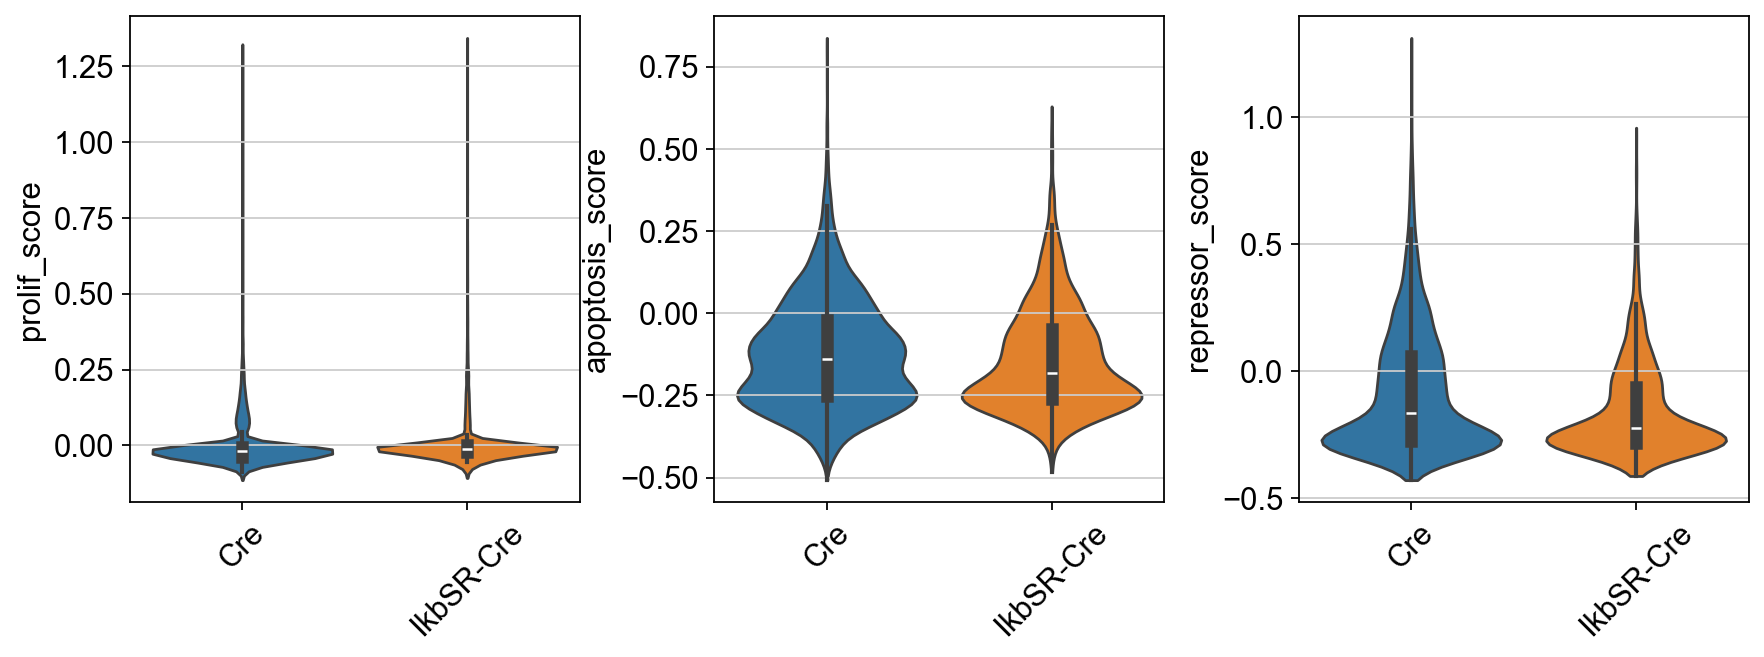

In [25]:
# Check if IkbSR-Cre has fewer cells in scRNA-seq
cell_counts = adata.obs['Group'].value_counts()
print(cell_counts)

# If HP2 has dramatically fewer cells than HP1, this supports selection

# Look at proliferation/apoptosis markers
proliferation_genes = ['Mki67', 'Pcna', 'Top2a', 'Ccnb1']
apoptosis_genes = ['Bax', 'Bak1', 'Casp3', 'Casp7', 'Casp9']
repressor_genes = ['Nfkbia', 'Nos2', 'Ptgs2', 'Il12b', 'Ccl2']

# Score these
sc.tl.score_genes(adata, gene_list=proliferation_genes, score_name='prolif_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=apoptosis_genes, score_name='apoptosis_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=repressor_genes, score_name='repressor_score',use_raw=True)

# Compare
sc.pl.violin(adata, keys=['prolif_score', 'apoptosis_score','repressor_score'], 
             groupby='Group',rotation=45, stripplot=False, inner='box')

# If HP2 cells have LOWER proliferation than HP1,
# but tumor burden isn't reduced → selection for slow-cycling resistant cells

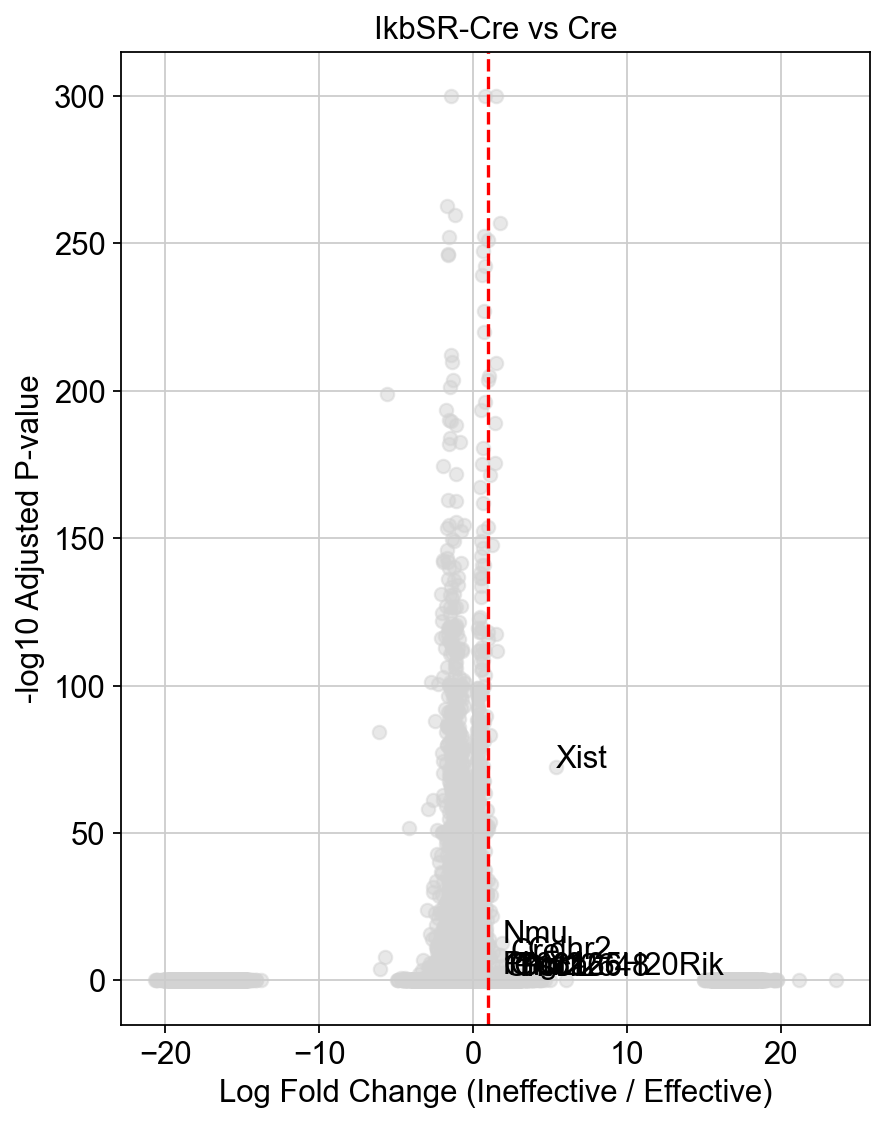

In [26]:
# 2. Extract the data for the volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['IkbSR-Cre'],
    'logfoldchanges': result['logfoldchanges']['IkbSR-Cre'],
    'pvals_adj': result['pvals_adj']['IkbSR-Cre']
})

# 3. Plotting
plt.figure(figsize=(6, 8))
plt.scatter(df['logfoldchanges'], -np.log10(df['pvals_adj'] + 1e-300), 
            alpha=0.5, c='lightgrey')

# Highlight top cycling and NF-kB genes
top_genes = df[df['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False).head(10)
for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj'] + 1e-300), row['gene'])

plt.axvline(1, color='red', linestyle='--')
plt.xlabel('Log Fold Change (Ineffective / Effective)')
plt.ylabel('-log10 Adjusted P-value')
plt.title('IkbSR-Cre vs Cre')
plt.show()

In [27]:
import gseapy as gp

# Define the genes that are HIGHER
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))

                                 Term  Adjusted P-value  Combined Score
0                         Coagulation          0.000086      114.821546
1                             Hypoxia          0.000127       79.667371
2              Estrogen Response Late          0.000567       59.571561
3                          Complement          0.002548       43.005948
4                IL-2/STAT5 Signaling          0.008992       29.969410
5                   KRAS Signaling Up          0.008992       29.682762
6                         Pperoxisome          0.009552       39.675761
7             Cholesterol Homeostasis          0.016000       40.121436
8   Epithelial Mesenchymal Transition          0.022638       19.307785
9                          Glycolysis          0.022638       19.307785
10                        p53 Pathway          0.022638       19.307785
11                       Adipogenesis          0.070415       11.575806
12            Estrogen Response Early          0.070415       11

In [28]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='Cre'].obs['prolif_score']
hp2_classical = adata[adata.obs['Group']=='IkbSR-Cre'].obs['prolif_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0000


## Explore Phase

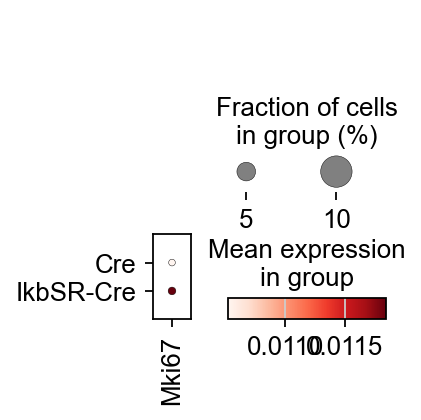

In [29]:
sc.pl.dotplot(adata,['Mki67'],groupby='Group',use_raw=True)

In [30]:
cell_cycle_genes = [x.strip() for x in open('../../common_files/regev_lab_cell_cycle_genes_mouse.txt')]

In [31]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [32]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes,use_raw=True)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    601 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA
    with n_comps=12


/home/chanj2/part2a-decoupler/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


    finished (0:00:01)


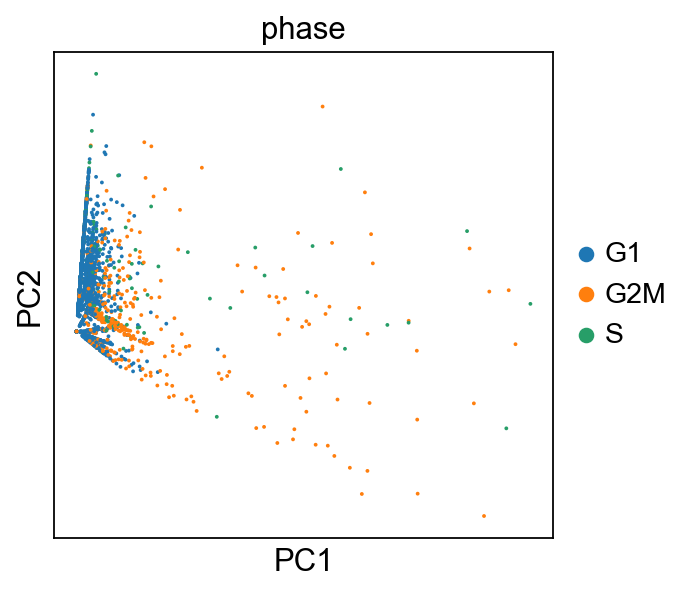

In [33]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

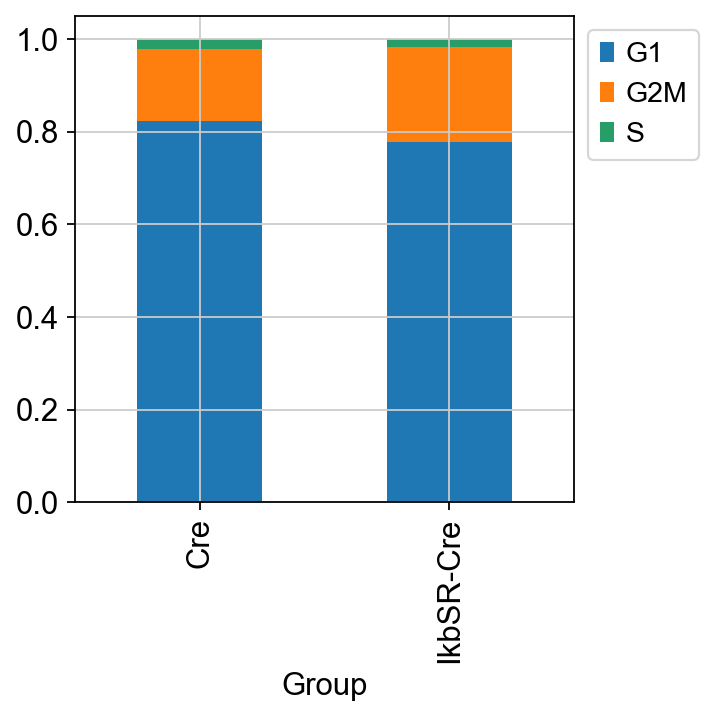

In [34]:
 cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [35]:
cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T
cell_proportion_df

phase            G1       G2M         S
Group                                  
Cre        0.824119  0.153896  0.021985
IkbSR-Cre  0.777449  0.205527  0.017024

In [36]:
adata.obs[['Classification','Group','phase']].value_counts(sort=False)


Classification  Group      phase
AY1262_B0306    IkbSR-Cre  G1        111
                           G2M        19
                           S           6
AY1263_B0307    IkbSR-Cre  G1        343
                           G2M        73
                           S           9
AY1264_B0301    Cre        G1       1285
                           G2M       180
                           S          46
AY1267_B0302    Cre        G1        441
                           G2M       103
                           S          11
AY1268_B0303    Cre        G1        814
                           G2M       199
                           S          22
AY1271_B0305    Cre        G1       1334
                           G2M       159
                           S          37
AY1422_B0304    Cre        G1       1224
                           G2M       311
                           S          20
AY1425_B0308    IkbSR-Cre  G1        797
                           G2M       182
                        

computing score 'STAT3_score'
    finished: added
    'STAT3_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'PI3K/AKT_score'
    finished: added
    'PI3K/AKT_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'WNT_score'
    finished: added
    'WNT_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'MAPK_score'
    finished: added
    'MAPK_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'HIF_score'
    finished: added
    'HIF_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)


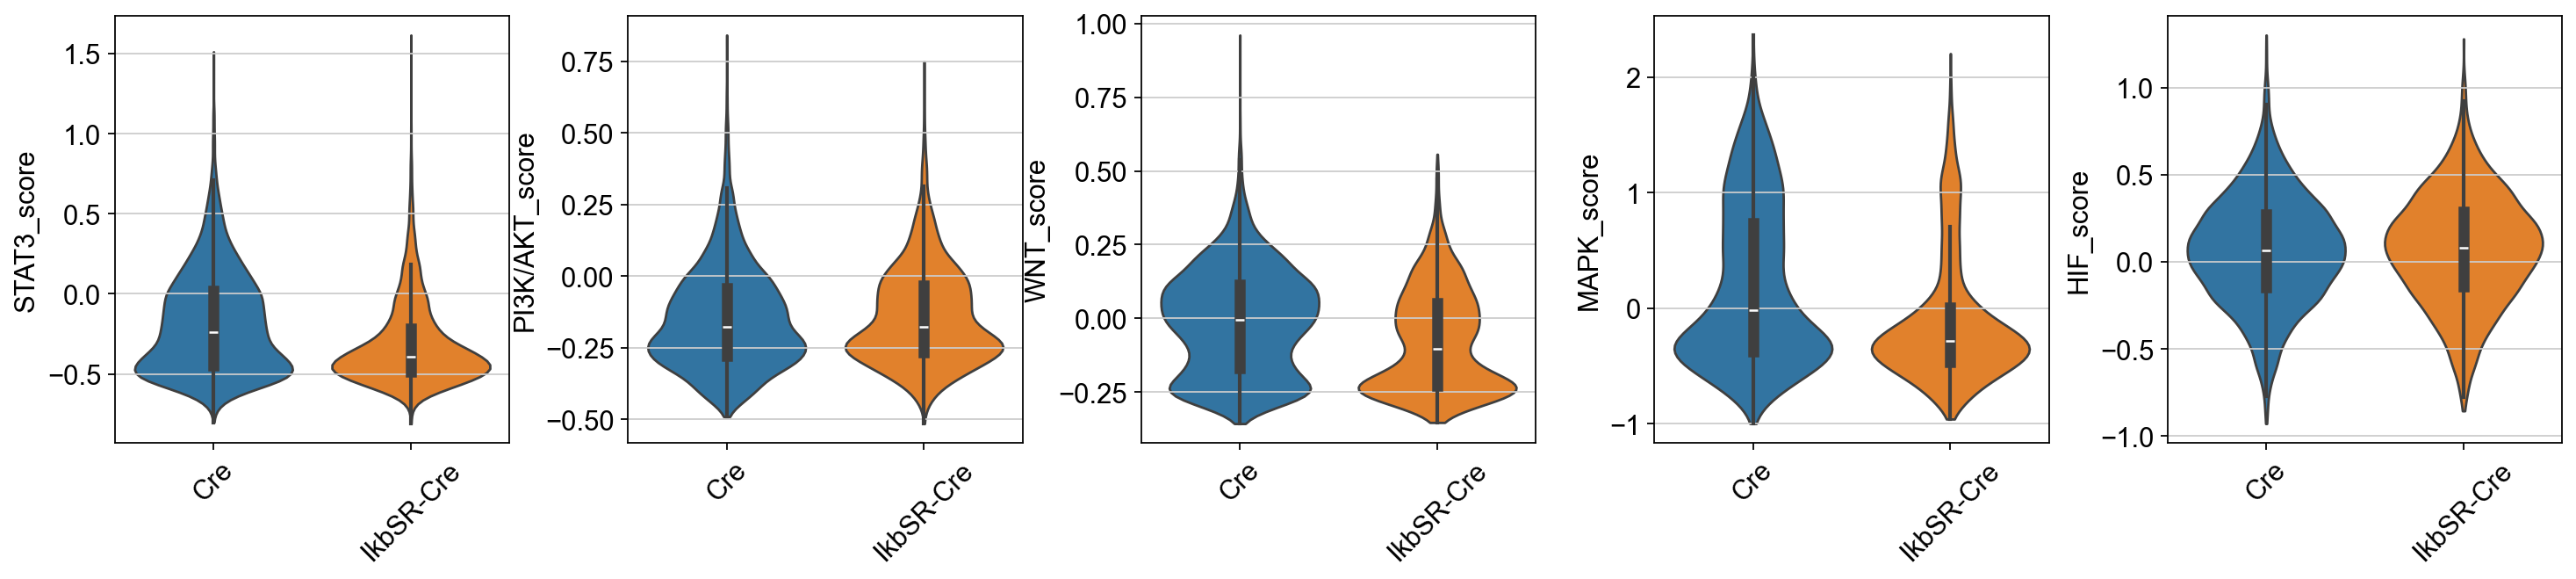

                     Cre  IkbSR-Cre  IkbSR-Cre_vs_Cre
WNT_score      -0.011588  -0.076122          6.568842
STAT3_score    -0.184951  -0.318098          1.719901
HIF_score       0.064412   0.072446          1.124736
PI3K/AKT_score -0.146796  -0.139471          0.950101
MAPK_score      0.190974  -0.118845         -0.622311


In [37]:
# Check alternative survival pathways
survival_pathways = {
    'STAT3': ['Stat3', 'Socs3', 'Bcl2l1', 'Mcl1'],
    'PI3K/AKT': ['Akt1', 'Akt2', 'Pdk1', 'Mtor'],
    'WNT': ['Ctnnb1', 'Axin2', 'Lef1', 'Tcf7'],
    'MAPK': ['Mapk1', 'Mapk3', 'Fos', 'Jun'],
    'HIF': ['Hif1a', 'Vegfa', 'Ldha', 'Pgk1']
}

# Score each pathway
for pathway, genes in survival_pathways.items():
    sc.tl.score_genes(adata, gene_list=genes, 
                     score_name=f'{pathway}_score',use_raw=True)

# Compare across groups
pathway_scores = [f'{p}_score' for p in survival_pathways.keys()]
sc.pl.violin(adata, keys=pathway_scores, groupby='Group', rotation=45, stripplot=False, inner='box')

# Look for HP2-specific upregulation
import pandas as pd
pathway_comparison = pd.DataFrame()
for score in pathway_scores:
    for group in ['Cre', 'IkbSR-Cre']:
        cells = adata.obs['Group'] == group
        pathway_comparison.loc[score, group] = adata[cells].obs[score].mean()

pathway_comparison['IkbSR-Cre_vs_Cre'] = (pathway_comparison['IkbSR-Cre'] / 
                                    pathway_comparison['Cre'])
print(pathway_comparison.sort_values('IkbSR-Cre_vs_Cre', ascending=False))

# If any pathway shows >1.5x in HP2 vs HP1 → compensation mechanism

computing score 'stemness_score'
    finished: added
    'stemness_score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)


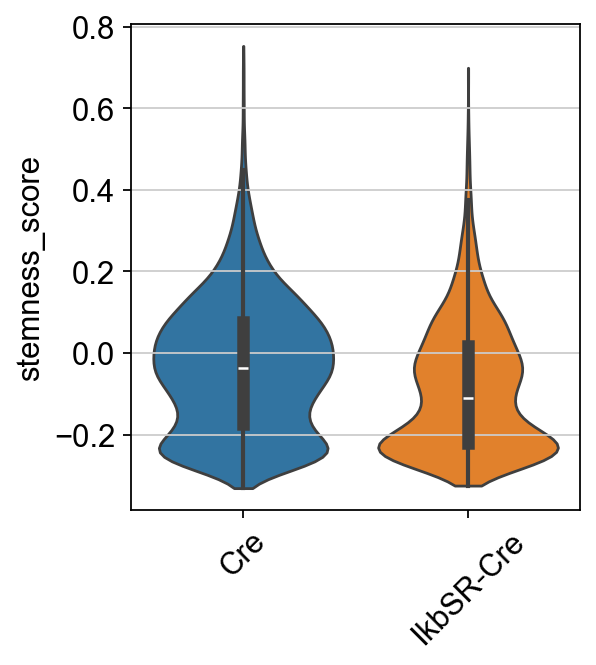

In [38]:
# p50 tumor suppressor functions:
# - Limits cancer stem cell self-renewal
# - Promotes differentiation
# - Limits metabolic reprogramming

# Check stem cell markers
stemness_genes = ['Cd44', 'Aldh1a1', 'Sox2', 'Nanog', 'Pou5f1']
differentiation_genes = ['Krt18', 'Cdh1', 'Epcam']  # Adjust for your tumor type

sc.tl.score_genes(adata, gene_list=stemness_genes, score_name='stemness_score',use_raw=True)

sc.pl.violin(adata, keys='stemness_score', groupby='Group',rotation=45, inner='box', stripplot=False)

# If HP2 has HIGHER stemness → too much p50 loss promotes cancer stem cells
# This would maintain tumor burden despite NFκB suppression


### 4. **Non-Linear Dose Response / "Goldilocks Zone"**



In [39]:
# Are different cell states enriched in HP2?
from scipy.stats import chi2_contingency

contingency = pd.crosstab(adata.obs['leiden'], adata.obs['Group'])
chi2, pval, dof, expected = chi2_contingency(contingency)

print(f"Cell composition differs across groups: p={pval:.2e}")

# Which clusters are enriched in HP2?
props = pd.crosstab(adata.obs['leiden'], adata.obs['Group'], normalize='columns')
props['HP2_enrichment'] = props['IkbSR-Cre'] / props['Cre']
print(props.sort_values('HP2_enrichment', ascending=False))

# If certain clusters are enriched in HP2 → selection

Cell composition differs across groups: p=1.01e-274
Group        Cre  IkbSR-Cre  HP2_enrichment
leiden                                     
1       0.393146   0.737972        1.877095
2       0.094568   0.074759        0.790533
3       0.091012   0.055268        0.607258
0       0.349822   0.117937        0.337135
4       0.037181   0.011843        0.318527
5       0.015196   0.001234        0.081185
6       0.019075   0.000987        0.051738


In [40]:
# Known NFκB-independent survival genes
resistance_genes = ['Yap1', 'Taz', 'Myc', 'Sox2', 'Stat3', 'Akt1','Sox11']

resistance_expr = pd.DataFrame()
for gene in resistance_genes:
    if gene in adata.var_names:
        for group in ['Cre', 'IkbSR-Cre']:
            cells = adata.obs['Group'] == group
            resistance_expr.loc[gene, group] = adata.raw[cells, gene].X.mean()

resistance_expr['HP2_vs_HP1'] = (resistance_expr['IkbSR-Cre'] / 
                                 resistance_expr['Cre'])
print(resistance_expr.sort_values('HP2_vs_HP1', ascending=False))

# Genes >2x in HP2 → compensation mechanisms

            Cre  IkbSR-Cre  HP2_vs_HP1
Akt1   0.486889   0.484550    0.995196
Sox2   0.003315   0.002583    0.779330
Taz    0.095293   0.051686    0.542388
Yap1   0.129235   0.060947    0.471595
Stat3  0.342779   0.159492    0.465290
Myc    0.094862   0.042192    0.444775
Sox11  0.002387   0.000000    0.000000


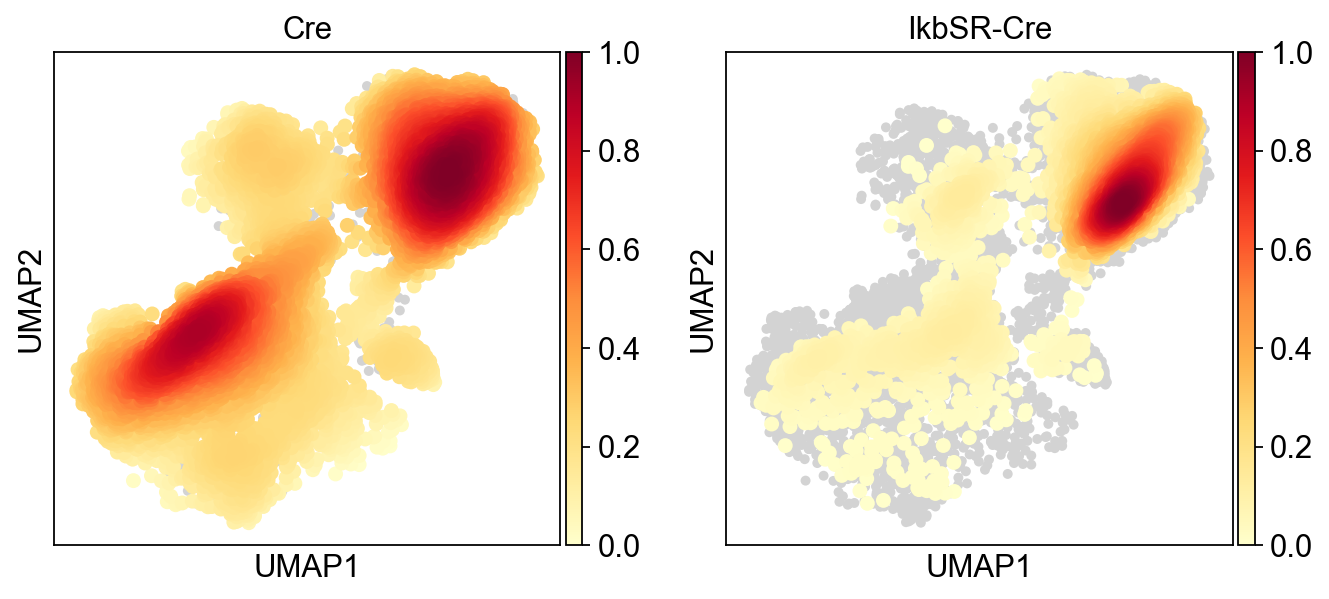

In [41]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_Group')

## Define scoring functions

In [42]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'cell2020_no_Slc4a11':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']   
                    if 'Slc4a11' in clusters[row[0]]:
                        clusters[row[0]].remove('Slc4a11')
                        print("Slc4a11 removed")
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'nfkb':         
            with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                clusters['nfkb'] = [x for row in csvreader for x in row]
            clusterkeys.append('nfkb')
            HPCS = 'nfkb'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [43]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes,use_raw=True)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [44]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1489 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1296 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1294 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1396 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1391 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    1792 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    1287 total control genes are u

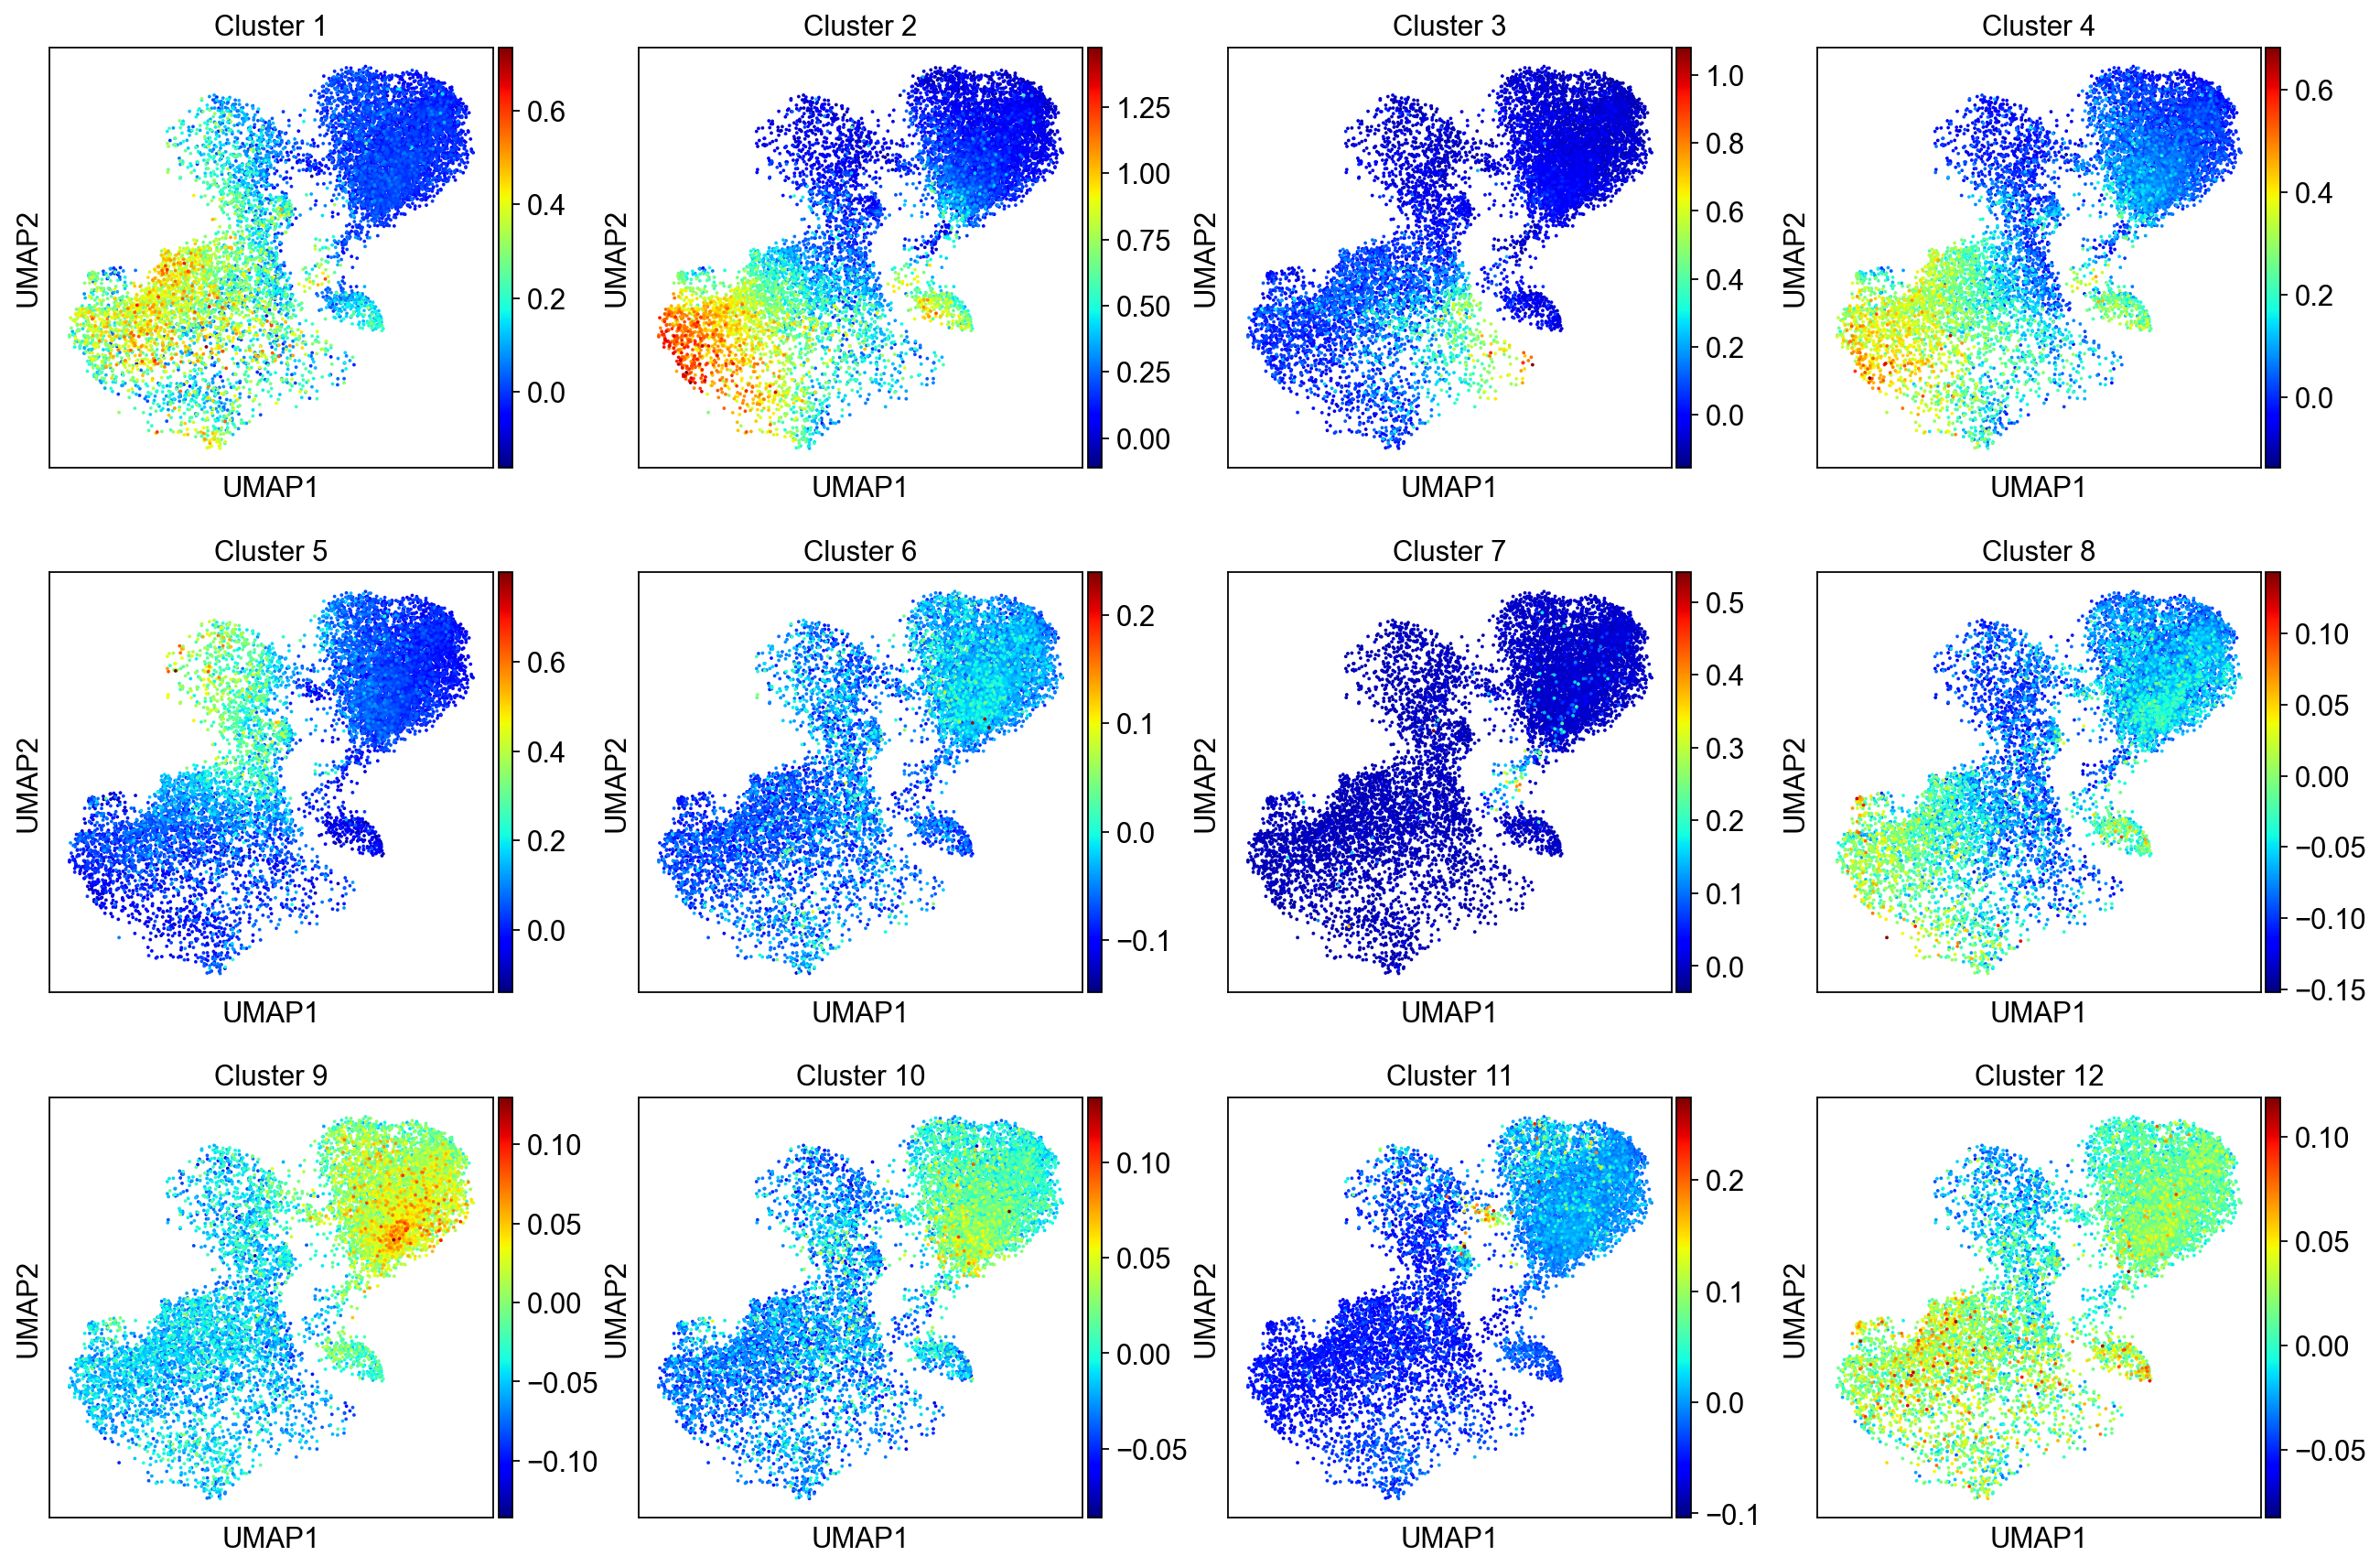

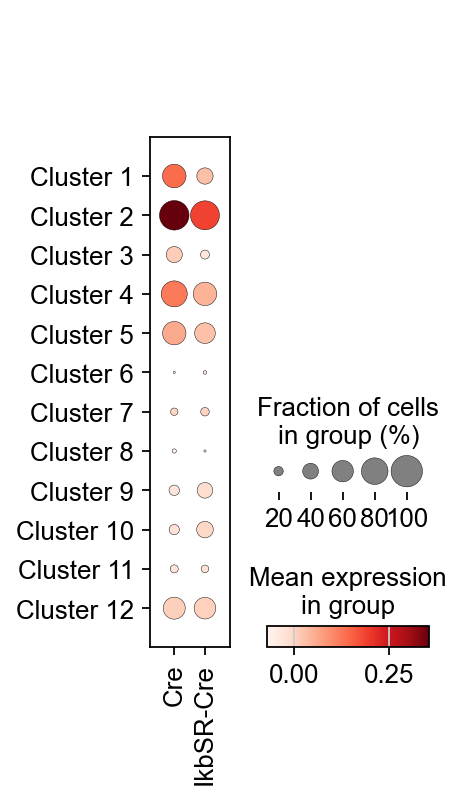

In [45]:
scoreAndPlot(adata, groupby='Group',numgenes=100)

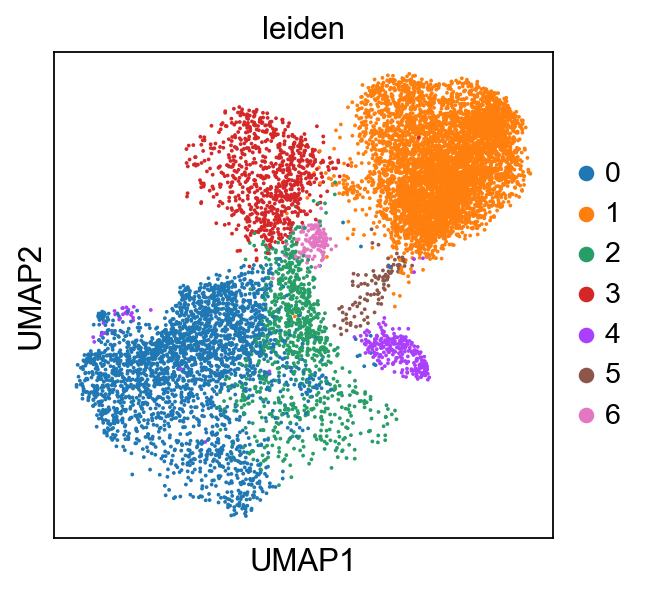

In [46]:
sc.pl.umap(adata,color=['leiden'])

In [47]:
df

gene  logfoldchanges      pvals_adj
0       Cystm1        0.791474   0.000000e+00
1       S100a6        1.460689   0.000000e+00
2         Msln        1.771595  1.050625e-257
3        Wfdc2        0.686516  2.613144e-253
4      S100a14        0.998722  5.572141e-252
...        ...             ...            ...
30139    H2-Aa       -1.653481  2.889799e-247
30140   H2-Ab1       -1.533653  4.745504e-253
30141    H2-Q7       -1.197796  1.894805e-260
30142   Cxcl16       -1.700520  2.111352e-263
30143     Cd74       -1.413437  6.299942e-304

[30144 rows x 3 columns]

In [48]:
df = adata.obs.copy()

pb_cluster5 = (
    df.groupby(["Classification", "Group"])["Cluster 5"]
      .mean()
      .reset_index()
)

pb_nfkb = (
    df.groupby(["Classification", "Group"])["hallmark_nfkb"]
      .mean()
      .reset_index()
)

# df2 = adata[~adata.obs.Classification.isin(['AX1508_2117','AX1598_2117','AW1555_2118']),:].obs.copy()
# pb_cluster5a = (
#     df2.groupby(["Classification", "Group"])["Cluster 5"]
#       .mean()
#       .reset_index()
# )
# pb_nfkba = (
#     df2.groupby(["Classification", "Group"])["hallmark_nfkb"]
#       .mean()
#       .reset_index()
# )

/tmp/ipykernel_48357/2583428365.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Cluster 5"]
/tmp/ipykernel_48357/2583428365.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["hallmark_nfkb"]


Text(0, 0.5, 'Mean hallmark_nfkb expression per mouse')

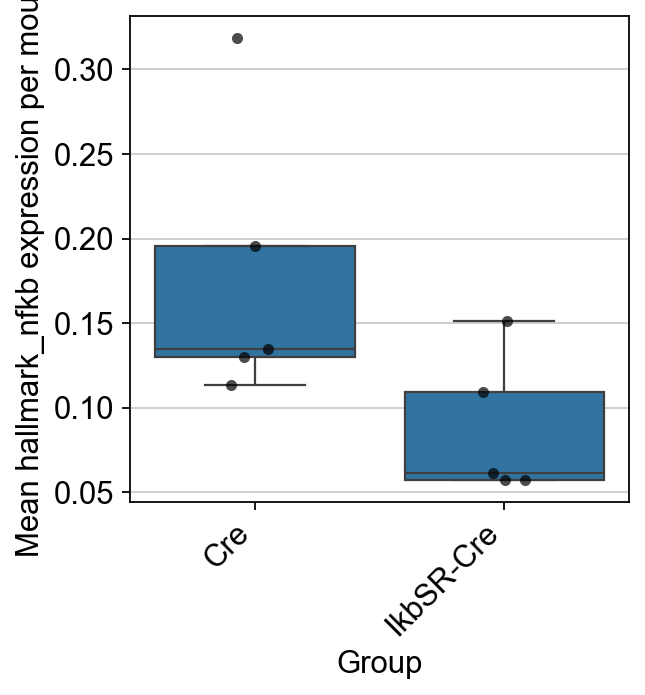

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    showfliers=False,
)
sns.stripplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean hallmark_nfkb expression per mouse")


Text(0, 0.5, 'Mean Cluster 5 expression per mouse')

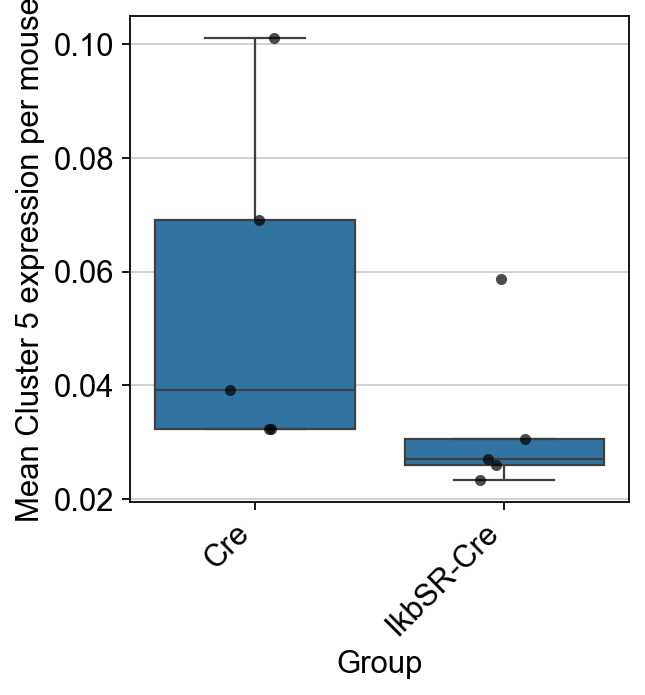

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    showfliers=False,
)
sns.stripplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Cluster 5 expression per mouse")


## Evaluate differentially expressed genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


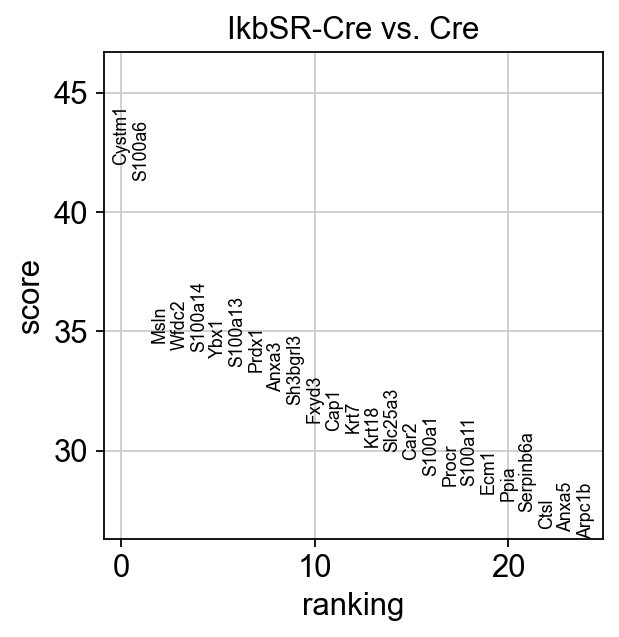

    using 'X_pca' with n_pcs = 150
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: IkbSR-Cre


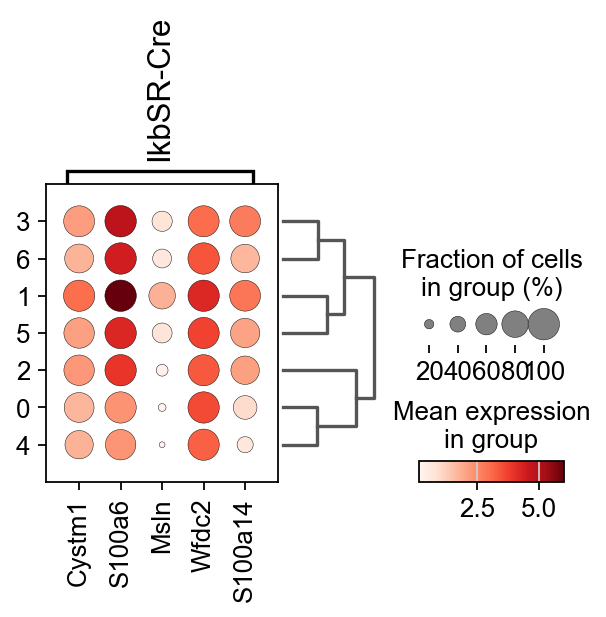

In [51]:
sc.tl.rank_genes_groups(adata, 'Group', method='wilcoxon',reference='Cre',use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="leiden")


## Look at the whole tumor

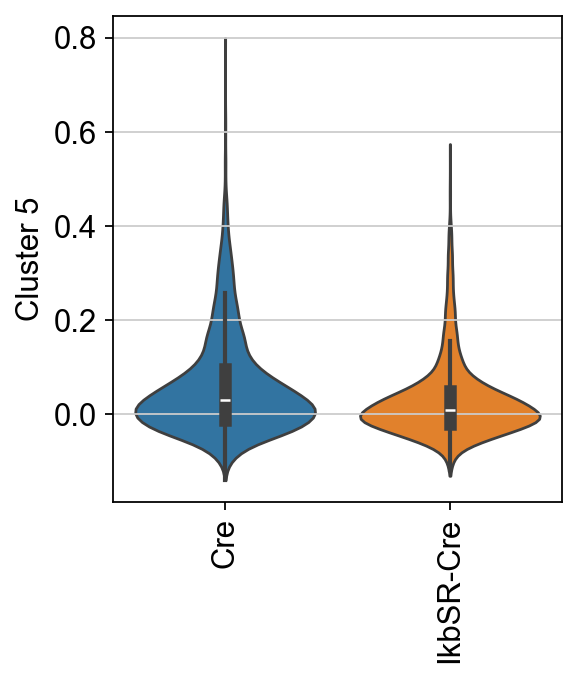

In [52]:
sc.pl.violin(adata, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [53]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['Cre']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['IkbSR-Cre']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(14681065.0), pvalue=np.float64(1.0694517089275049e-48))

## Now look within the HPCS cluster

In [54]:
adata2 = adata[adata.obs.leiden.isin(['3']),:].copy()

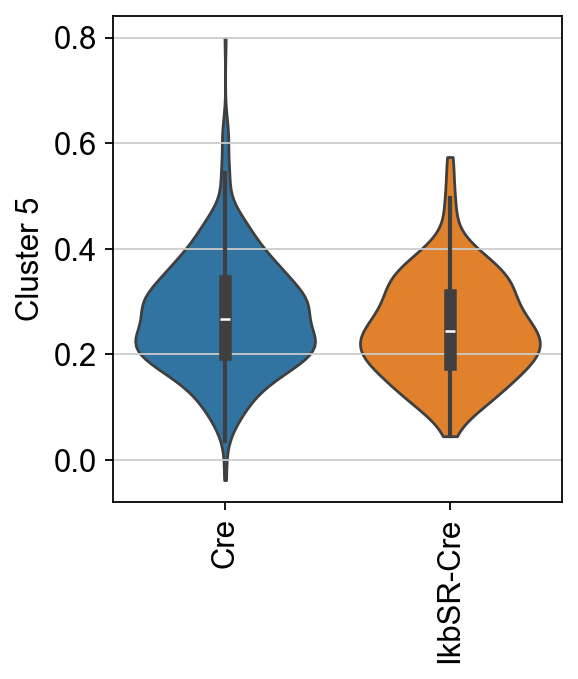

In [55]:
sc.pl.violin(adata2, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [56]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['Cre']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['IkbSR-Cre']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(70870.0), pvalue=np.float64(0.0066244386375118895))

## Evaluate differences in HPCS between groups via Enrichr

In [57]:
result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names
results_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','scores']}) #.to_excel('test.xlsx')
#results_df.to_excel('write/leiden.xlsx')

In [58]:
import gseapy
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Mouse')
print(gene_set_names)
#gsets = 'Descartes_Cell_Types_and_Tissue_2021'
#gsets = 'Tabula_Muris'
gsets = 'MSigDB_Hallmark_2020'
#gsets = 'The_Kinase_Library_2023'
#gsets = 'TF_Perturbations_Followed_by_Expression'

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CM4AI_U2OS_Protein_Localization_Assemblies', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'Carcinogenome', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'ClinVar_2025', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency

In [59]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['IkbSR-Cre'],
    'logfoldchanges': result['logfoldchanges']['IkbSR-Cre'],
    'pvals_adj': result['pvals_adj']['IkbSR-Cre']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr0 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr0.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr0.results.to_excel('write/GSEA_IkbSR-Cre_up.xlsx')

                                 Term  Adjusted P-value  Combined Score
0                         Coagulation          0.000086      114.821546
1                             Hypoxia          0.000127       79.667371
2              Estrogen Response Late          0.000567       59.571561
3                          Complement          0.002548       43.005948
4                IL-2/STAT5 Signaling          0.008992       29.969410
5                   KRAS Signaling Up          0.008992       29.682762
6                         Pperoxisome          0.009552       39.675761
7             Cholesterol Homeostasis          0.016000       40.121436
8   Epithelial Mesenchymal Transition          0.022638       19.307785
9                          Glycolysis          0.022638       19.307785
10                        p53 Pathway          0.022638       19.307785
11                       Adipogenesis          0.070415       11.575806
12            Estrogen Response Early          0.070415       11

In [60]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['IkbSR-Cre'],
    'logfoldchanges': result['logfoldchanges']['IkbSR-Cre'],
    'pvals_adj': result['pvals_adj']['IkbSR-Cre']
})
# Define the genes that are LOWER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr1 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr1.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr1.results.to_excel('write/GSEA_IkbSR-Cre_down.xlsx')

                             Term  Adjusted P-value  Combined Score
0   TNF-alpha Signaling via NF-kB      7.032367e-30      405.204407
1                  Myc Targets V1      3.027042e-27      330.964403
2                     p53 Pathway      1.842992e-18      161.792029
3       Interferon Gamma Response      6.473439e-17      138.112027
4               Protein Secretion      1.299021e-15      217.784203
5       Unfolded Protein Response      1.299021e-15      183.058109
6                    Adipogenesis      4.133332e-13       89.154522
7              TGF-beta Signaling      4.192371e-12      244.106338
8       Oxidative Phosphorylation      2.066242e-11       70.825045
9       Interferon Alpha Response      2.394825e-11      110.019944
10                Mitotic Spindle      7.789684e-11       64.766670
11                      Apoptosis      4.453191e-10       63.957881
12               mTORC1 Signaling      1.651075e-09       52.378031
13           IL-2/STAT5 Signaling      2.533755e

In [61]:
adata.obs['Group'].value_counts()

Group
Cre          6186
IkbSR-Cre    4053
Name: count, dtype: int64

<Axes: title={'center': 'MSigDB_Hallmark_2020 IkbSR-Cre Down'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

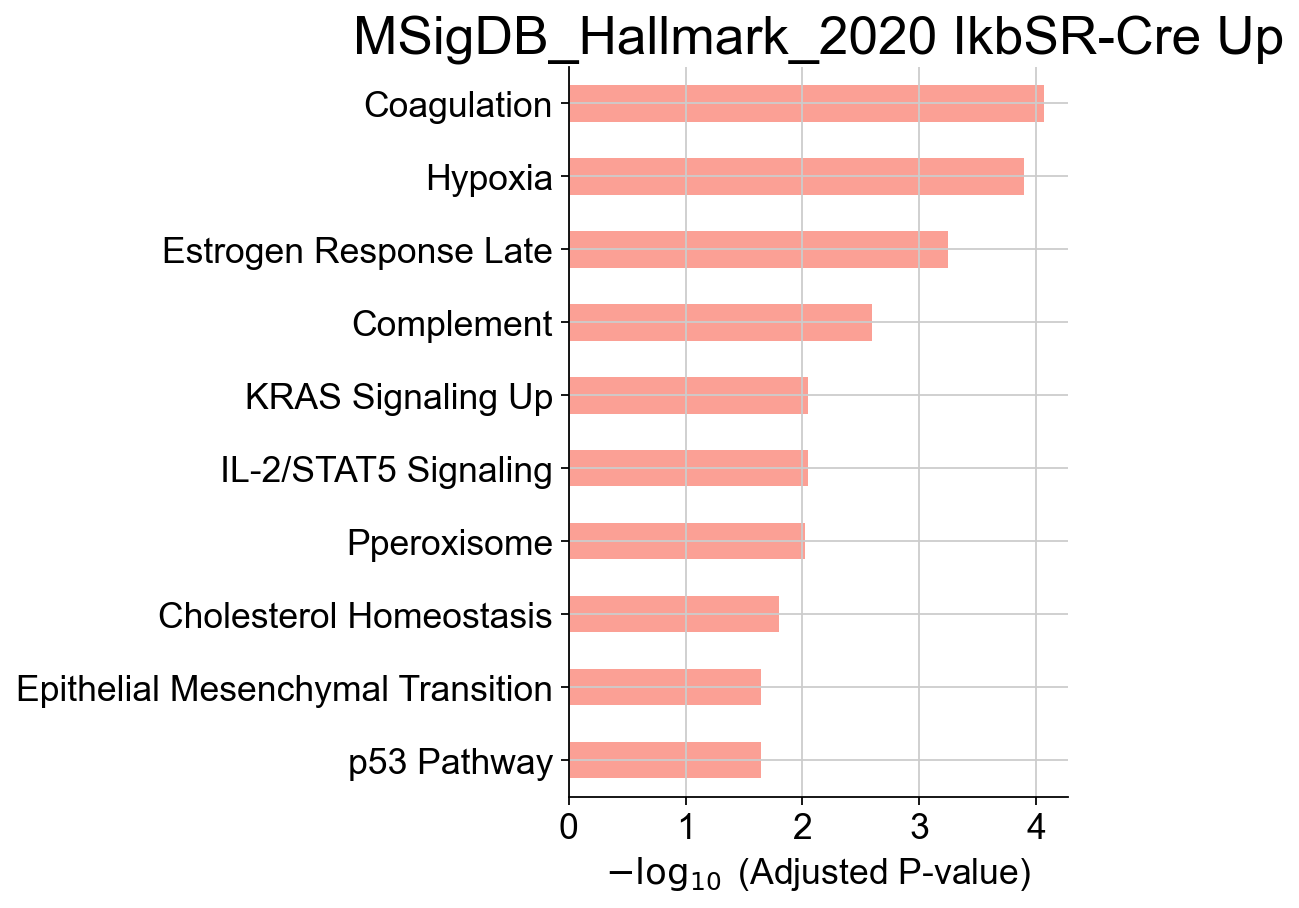

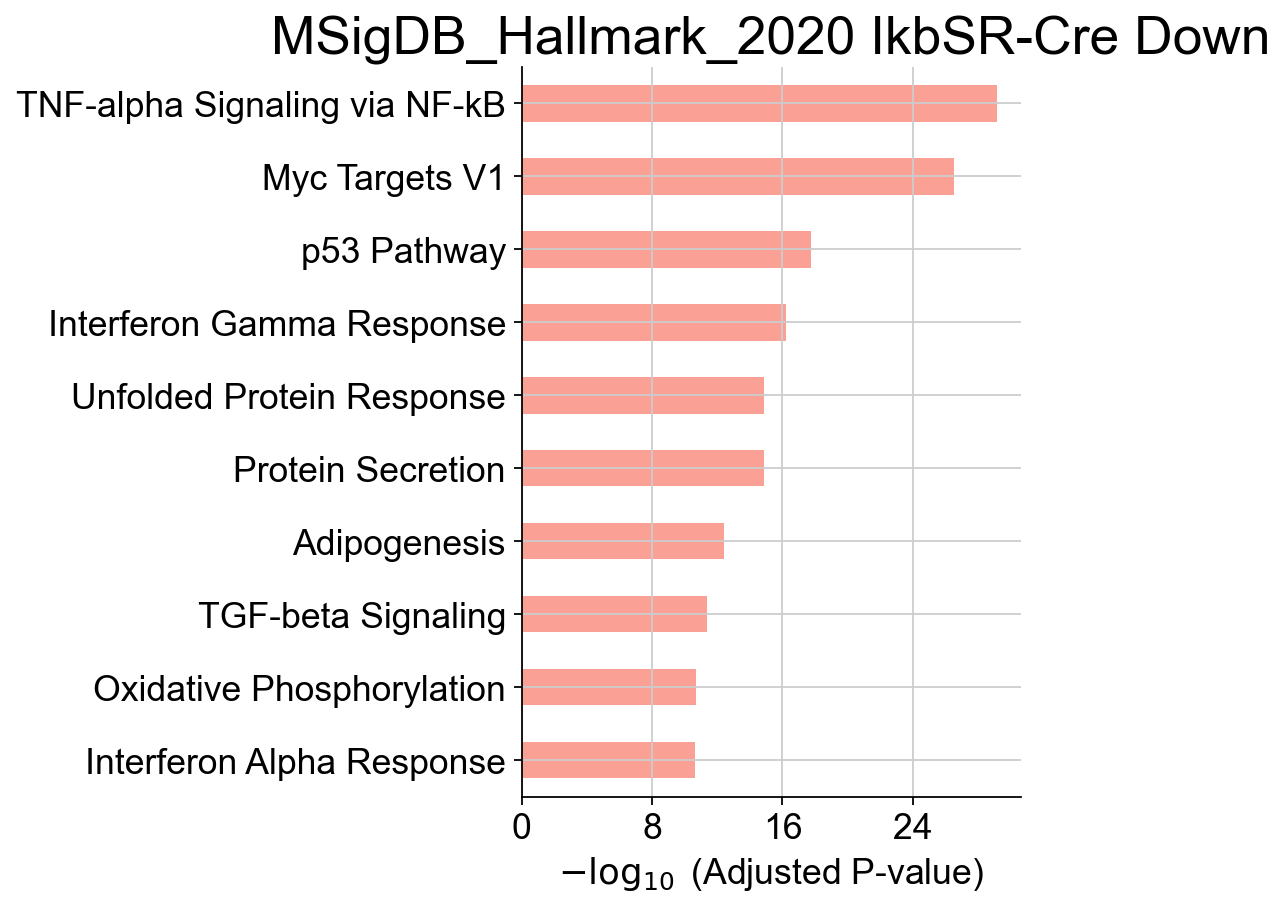

In [62]:
gseapy.barplot(enr0.res2d,title="%s IkbSR-Cre Up" % gsets)
gseapy.barplot(enr1.res2d,title="%s IkbSR-Cre Down" % gsets)

## EnrichR using Cancer Cell Clusters

In [63]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['IkbSR-Cre'],
    'logfoldchanges': result['logfoldchanges']['IkbSR-Cre'],
    'pvals_adj': result['pvals_adj']['IkbSR-Cre']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr0a = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=[clusters],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr0a.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr0a.results.to_excel('write/EnrichR_Clusters_IkbSR-Cre_up.xlsx')

         Term  Adjusted P-value  Combined Score
0   Cluster 1          0.999933        0.037293
1  Cluster 10          0.000983       27.419282
2  Cluster 11          0.831178        1.698374
3  Cluster 12          0.981829        0.639346
4   Cluster 3          0.999933        0.070814
5   Cluster 5          0.051372       10.032913
6   Cluster 6          0.908222        1.076537
7   Cluster 7          0.999933        0.000010
8   Cluster 9          0.984419        0.420179


In [64]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['IkbSR-Cre'],
    'logfoldchanges': result['logfoldchanges']['IkbSR-Cre'],
    'pvals_adj': result['pvals_adj']['IkbSR-Cre']
})
# Define the genes that are LOWER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr1a = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=[clusters],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr1a.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr1a.results.to_excel('write/EnrichR_Clusters_IkbSR-Cre_down.xlsx')

          Term  Adjusted P-value  Combined Score
0    Cluster 1      3.375803e-27    3.112450e+02
1   Cluster 10      1.000000e+00    4.129116e-05
2   Cluster 11      1.000000e+00   -0.000000e+00
3   Cluster 12      4.869772e-03    7.668087e+00
4    Cluster 2      1.091555e-10    1.238829e+02
5    Cluster 3      8.886849e-12    7.484664e+01
6    Cluster 4      7.372021e-04    1.955607e+01
7    Cluster 5      2.821902e-28    2.253828e+02
8    Cluster 6      1.658484e-02    5.628825e+00
9    Cluster 7      1.000000e+00   -0.000000e+00
10   Cluster 8      4.041461e-06    2.194142e+01
11   Cluster 9      1.000000e+00    1.190343e-07


In [65]:
adata.obs['Group'].value_counts()

Group
Cre          6186
IkbSR-Cre    4053
Name: count, dtype: int64

<Axes: title={'center': 'MSigDB_Hallmark_2020 IkbSR-Cre Down'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

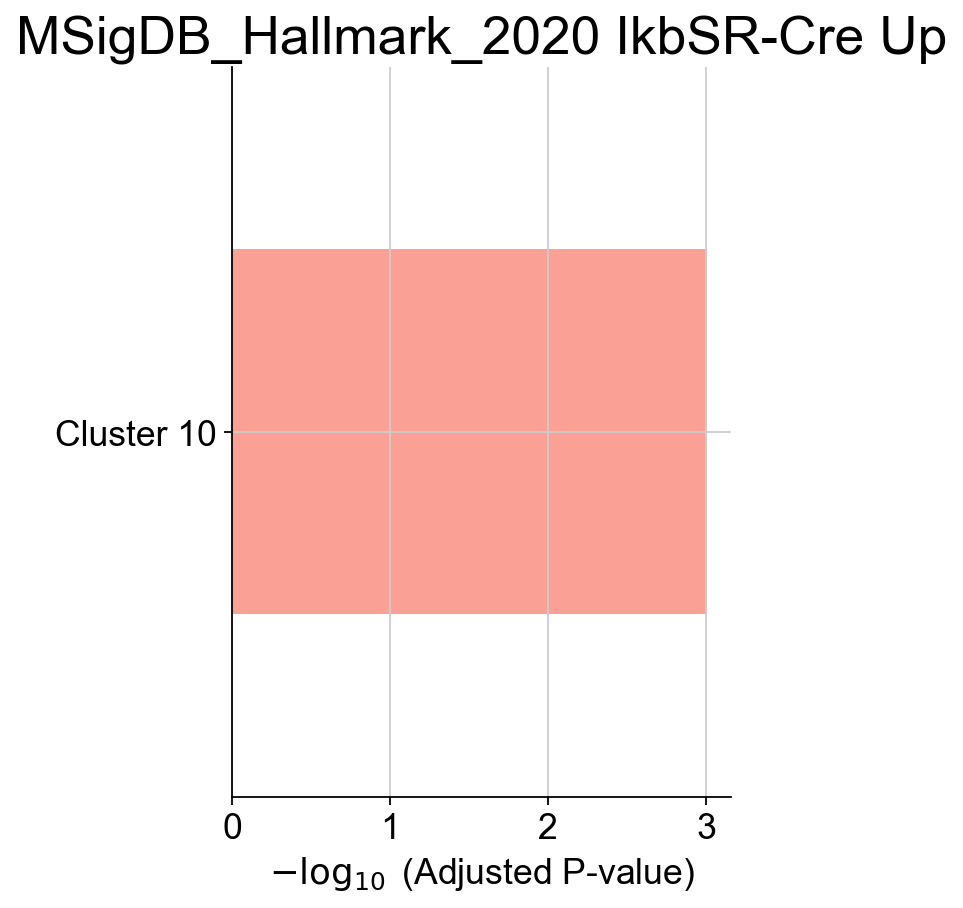

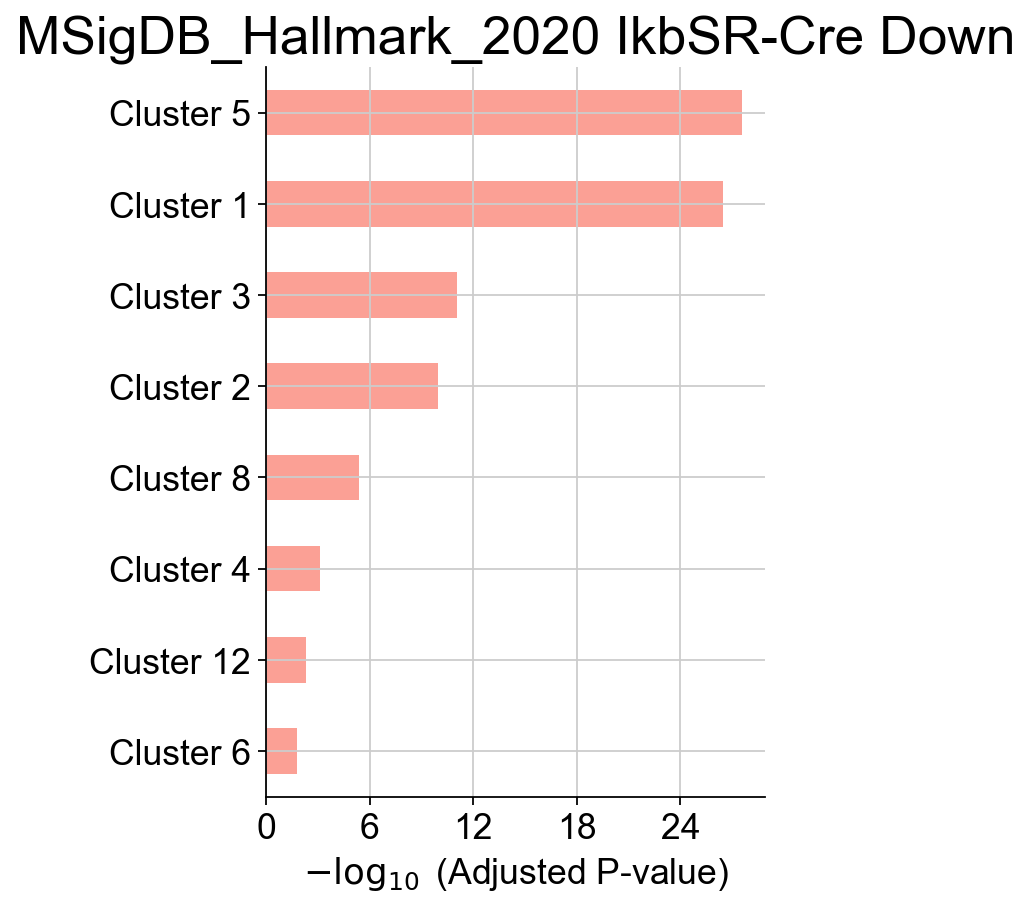

In [66]:
gseapy.barplot(enr0a.res2d,title="%s IkbSR-Cre Up" % gsets)
gseapy.barplot(enr1a.res2d,title="%s IkbSR-Cre Down" % gsets)

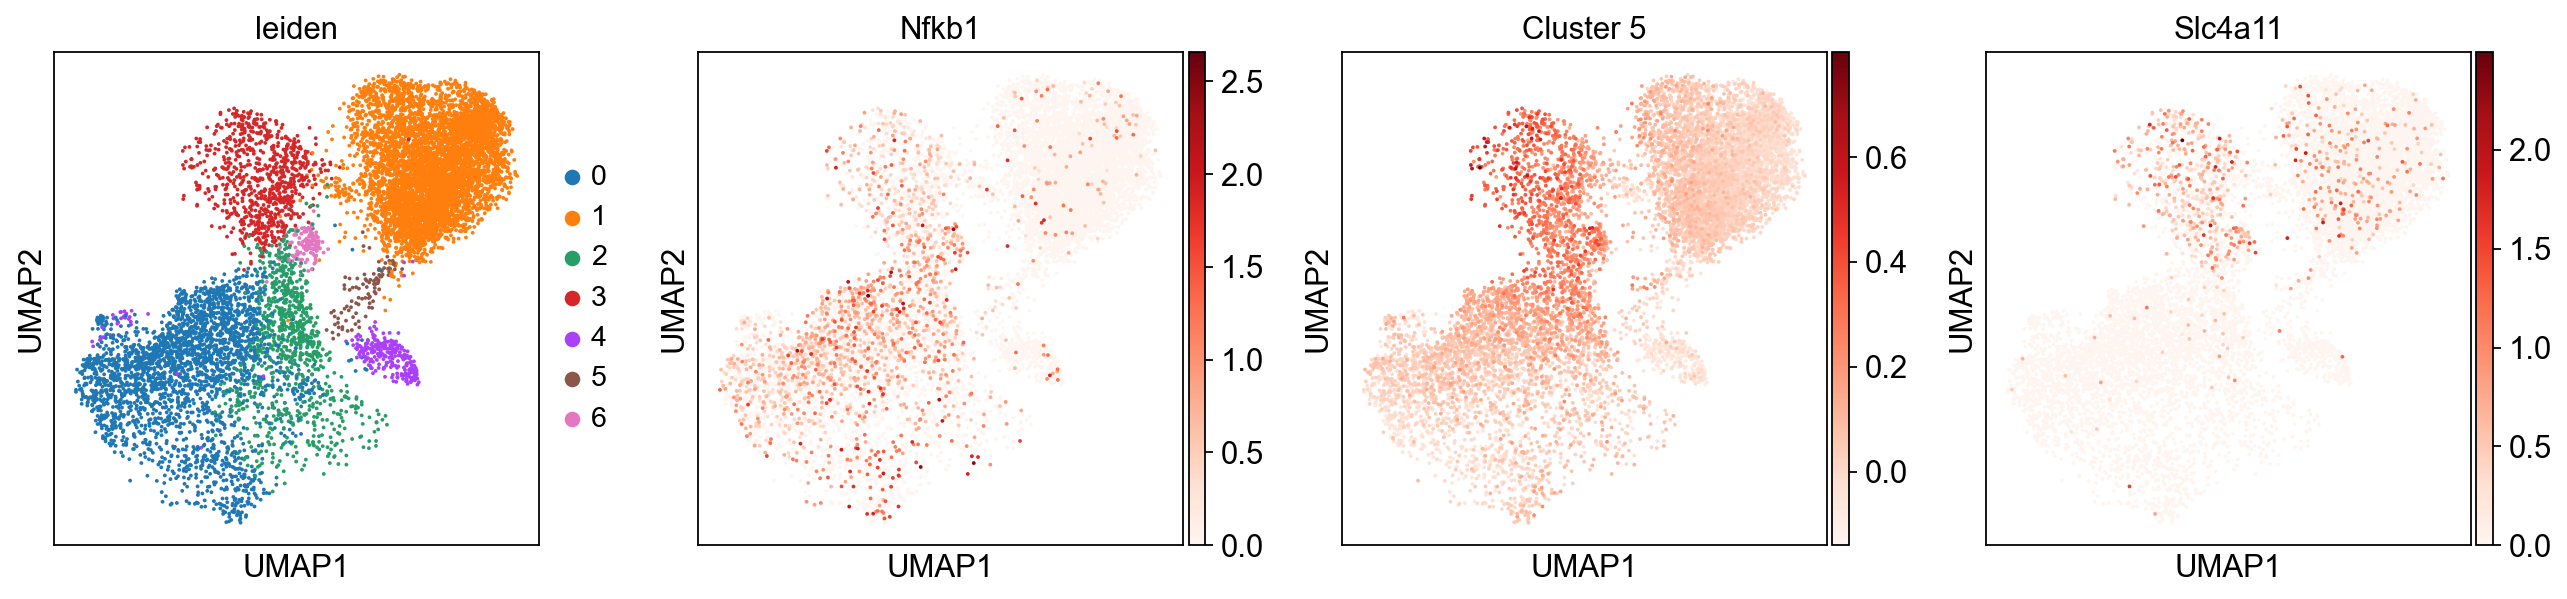

In [67]:
sc.pl.umap(adata, color=['leiden','Nfkb1','Cluster 5','Slc4a11'], cmap='Reds')

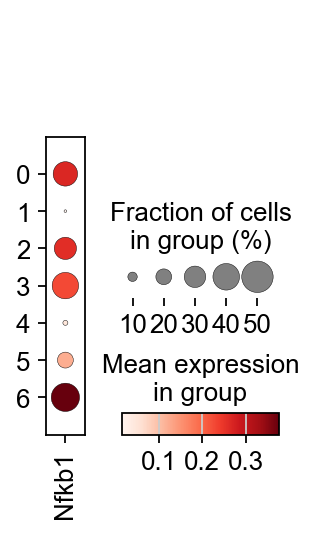

In [68]:
sc.pl.dotplot(adata, ['Nfkb1'], groupby='leiden',use_raw=True)

In [69]:
# Test if proportion of each cell state differs between conditions
# at the MOUSE level (proper statistics)

def test_state_proportions(adata, state_key='leiden', 
                           sample_key='Classification', 
                           condition_key='Group'):
    
    # Calculate proportion of each state per mouse
    proportions = []
    
    for mouse in adata.obs[sample_key].unique():
        adata_mouse = adata[adata.obs[sample_key] == mouse]
        condition = adata_mouse.obs[condition_key].iloc[0]
        
        state_counts = adata_mouse.obs[state_key].value_counts()
        state_props = state_counts / adata_mouse.n_obs
        
        for state, prop in state_props.items():
            proportions.append({
                'mouse_id': mouse,
                'condition': condition,
                'cell_state': state,
                'proportion': prop
            })
    
    props_df = pd.DataFrame(proportions)
    
    # Test each state (Wilcoxon or t-test with n=3 per group)
    from scipy.stats import mannwhitneyu
    
    for state in props_df['cell_state'].unique():
        state_data = props_df[props_df['cell_state'] == state]
        grp1 = state_data[state_data['condition'] == 'Cre']['proportion']
        grp2 = state_data[state_data['condition'] == 'IkbSR-Cre']['proportion']
        
        stat, pval = mannwhitneyu(grp1, grp2)
        print(f"{state}: p={pval:.4f}")

In [70]:
test_state_proportions(adata)

1: p=0.0556
0: p=0.0952
2: p=0.4206
3: p=0.0079
4: p=0.1508
5: p=0.0079
6: p=0.3810


## Evaluate differences in Groups via GSEA

In [71]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import ranksums, ttest_ind
from scipy.stats import false_discovery_control


# ========================================
# CREATE NORMALIZED PSEUDOBULK
# ========================================

def create_normalized_pseudobulk(adata, 
                                 sample_key='Classification',
                                 condition_key='Group',
                                 layer=None):
    """
    Create per-cell normalized pseudobulk matrix
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    sample_key : str
        Column in adata.obs with mouse/sample IDs
    condition_key : str
        Column in adata.obs with condition labels
    layer : str or None
        Which layer to use. None = use .X, 'raw' = use .raw.X
    
    Returns:
    --------
    pseudobulk_df : DataFrame
        Genes x Samples with per-cell averaged expression
    metadata_df : DataFrame
        Sample metadata
    """
    
    pseudobulk_list = []
    metadata_list = []
    
    for sample in adata.obs[sample_key].unique():
        # Subset to this mouse
        adata_sample = adata[adata.obs[sample_key] == sample].copy()
        
        # Get condition
        condition = adata_sample.obs[condition_key].iloc[0]
        n_cells = adata_sample.n_obs
        
        # Get counts - use raw counts for DE
        if layer is None:
            if adata_sample.raw is not None:
                counts = adata_sample.raw.X
            else:
                counts = adata_sample.X
        else:
            counts = adata_sample.layers[layer]
        
        # Sum across cells
        if hasattr(counts, 'toarray'):  # sparse matrix
            summed = np.array(counts.sum(axis=0)).flatten()
        else:
            summed = counts.sum(axis=0).flatten()
        
        # Normalize by cell number - this is key for enriched samples!
        per_cell_avg = summed / n_cells
        
        pseudobulk_list.append(per_cell_avg)
        metadata_list.append({
            'sample_id': sample,
            'condition': condition,
            'n_cells': n_cells
        })
    
    # Create DataFrame
    if adata.raw is not None:
        gene_names = adata.raw.var_names
    else:
        gene_names = adata.var_names
    
    pseudobulk_df = pd.DataFrame(
        np.array(pseudobulk_list).T,
        index=gene_names,
        columns=[m['sample_id'] for m in metadata_list]
    )
    
    metadata_df = pd.DataFrame(metadata_list)
    
    return pseudobulk_df, metadata_df

# Create pseudobulk
print("Creating normalized pseudobulk...")
pseudobulk, metadata = create_normalized_pseudobulk(
    adata2,
    sample_key='Classification',
    condition_key='Group'
)

print(f"Pseudobulk shape: {pseudobulk.shape}")
print(f"Samples: {metadata['sample_id'].tolist()}")
print(f"Conditions: {metadata['condition'].tolist()}")

# ========================================
# DIFFERENTIAL EXPRESSION TESTING
# ========================================

def run_de_analysis(pseudobulk_df, metadata_df, 
                    condition1='Cre', 
                    condition2='IkbSR-Cre',
                    min_expression=1.0,
                    test='wilcoxon'):
    """
    Run differential expression between two conditions
    
    Parameters:
    -----------
    pseudobulk_df : DataFrame
        Genes x Samples pseudobulk matrix
    metadata_df : DataFrame
        Sample metadata with 'condition' column
    condition1 : str
        Reference condition (denominator for fold change)
    condition2 : str
        Test condition (numerator for fold change)
    min_expression : float
        Minimum mean expression to include gene
    test : str
        'wilcoxon' or 'ttest'
    
    Returns:
    --------
    results_df : DataFrame
        DE results with logFC, p-values, etc.
    """
    
    # Get sample indices for each condition
    samples1 = metadata_df[metadata_df['condition'] == condition1]['sample_id'].values
    samples2 = metadata_df[metadata_df['condition'] == condition2]['sample_id'].values
    
    print(f"\nComparing {condition2} (n={len(samples2)}) vs {condition1} (n={len(samples1)})")
    print(f"  {condition1} samples: {samples1}")
    print(f"  {condition2} samples: {samples2}")
    
    # Filter genes by expression
    mean_expr = pseudobulk_df.mean(axis=1)
    genes_to_test = mean_expr[mean_expr >= min_expression].index
    print(f"  Testing {len(genes_to_test)} genes (mean expression >= {min_expression})")
    
    results = []
    
    for gene in genes_to_test:
        group1 = pseudobulk_df.loc[gene, samples1].values
        group2 = pseudobulk_df.loc[gene, samples2].values
        
        # Calculate means and fold change
        mean1 = np.mean(group1)
        mean2 = np.mean(group2)
        
        # Log2 fold change (add pseudocount to avoid log(0))
        log2fc = np.log2((mean2 + 1) / (mean1 + 1))
        
        # Statistical test
        if test == 'wilcoxon':
            try:
                stat, pval = ranksums(group1, group2)
            except:
                pval = 1.0
        elif test == 'ttest':
            stat, pval = ttest_ind(group1, group2)
        else:
            raise ValueError("test must be 'wilcoxon' or 'ttest'")
        
        results.append({
            'gene': gene,
            'mean_control': mean1,
            'mean_treatment': mean2,
            'log2FC': log2fc,
            'pval': pval
        })
    
    results_df = pd.DataFrame(results)
    
    # FDR correction
    results_df['padj'] = false_discovery_control(results_df['pval'].values)
    
    # Sort by p-value
    results_df = results_df.sort_values('pval')
    
    print(f"  Significant genes (padj < 0.05): {(results_df['padj'] < 0.05).sum()}")
    print(f"  Upregulated (log2FC > 0.5, padj < 0.05): {((results_df['log2FC'] > 0.5) & (results_df['padj'] < 0.05)).sum()}")
    print(f"  Downregulated (log2FC < -0.5, padj < 0.05): {((results_df['log2FC'] < -0.5) & (results_df['padj'] < 0.05)).sum()}")
    
    return results_df

# Run DE analysis
de_results = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='Cre',  # Change to your control condition name
    condition2='IkbSR-Cre',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results.to_csv('write/de_results_IkbSR-Cre_vs_Cre.csv', index=False)
print("\nSaved DE results to: de_results_IkbSR-Cre_vs_Cre.csv")

# ========================================
# CREATE RANKING METRIC FOR GSEA
# ========================================

def create_gsea_ranking(de_results_df, 
                       ranking_method='signed_pval'):
    """
    Create ranking metric for GSEA Prerank
    
    Parameters:
    -----------
    de_results_df : DataFrame
        DE results with gene, log2FC, pval columns
    ranking_method : str
        'signed_pval': -log10(pval) * sign(log2FC)
        'weighted_fc': log2FC * -log10(pval)
        'signal2noise': log2FC / SE (requires replicates)
    
    Returns:
    --------
    ranked_df : DataFrame
        Genes ranked for GSEA
    """
    
    df = de_results_df.copy()
    
    # Replace p=0 with minimum non-zero p-value
    min_pval = df[df['pval'] > 0]['pval'].min()
    df.loc[df['pval'] == 0, 'pval'] = min_pval / 10
    
    if ranking_method == 'signed_pval':
        # Classic approach: sign(FC) * -log10(pval)
        df['rank_metric'] = -np.log10(df['pval']) * np.sign(df['log2FC'])
        
    elif ranking_method == 'weighted_fc':
        # Weight fold change by significance
        df['rank_metric'] = df['log2FC'] * -np.log10(df['pval'])
        
    elif ranking_method == 'log2fc_only':
        # Just use fold change (not recommended for small n)
        df['rank_metric'] = df['log2FC']
    
    else:
        raise ValueError(f"Unknown ranking method: {ranking_method}")
    
    # Sort by ranking metric (high to low)
    df = df.sort_values('rank_metric', ascending=False)
    
    # Remove any NaN or infinite values
    df = df[np.isfinite(df['rank_metric'])]
    
    print(f"\nRanking method: {ranking_method}")
    print(f"Top 5 upregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].head())
    print(f"\nTop 5 downregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].tail())
    
    return df[['gene', 'rank_metric']]

# Create ranking
ranked_genes = create_gsea_ranking(
    de_results, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)

# ========================================
# EXPORT FOR GSEA PRERANK
# ========================================

# Save as .rnk file (tab-separated, no header)
output_file = 'write/IkbSR-Cre_vs_Cre.rnk'
ranked_genes.to_csv(
    output_file,
    sep='\t',
    header=False,
    index=False
)
print(f"\nSaved GSEA ranking file: {output_file}")
print(f"Total genes in ranking: {len(ranked_genes)}")

# ========================================
# 6. OPTIONAL: RUN GSEA IN PYTHON
# ========================================

# If you want to run GSEA directly in Python instead of using the GSEA app:

def run_gsea_prerank_python(ranked_genes_df, 
                           gene_sets='MSigDB_Hallmark_2020',
                           organism='Mouse',
                           output_dir='write/gsea_output'):
    """
    Run GSEA Prerank using gseapy
    
    Requires: pip install gseapy
    """
    try:
        import gseapy as gp
    except ImportError:
        print("gseapy not installed. Install with: pip install gseapy")
        return None
    
    print(f"\nRunning GSEA Prerank...")
    print(f"  Gene sets: {gene_sets}")
    print(f"  Organism: {organism}")
    
    # Run GSEA
    pre_res = gp.prerank(
        rnk=ranked_genes_df,
        gene_sets=gene_sets,
        organism=organism,
        outdir=output_dir,
        min_size=15,
        max_size=500,
        permutation_num=1000,
        seed=42,
        verbose=True
    )
    
    print(f"\nGSEA complete! Results saved to: {output_dir}")
    
    # Show top results
    results = pre_res.res2d
    results = results.sort_values('NOM p-val')
    
    print("\nTop 10 enriched pathways:")
    print(results[['Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val']].head(10))
    
    return pre_res

# run GSEA in Python:
gsea_results = run_gsea_prerank_python(
     ranked_genes,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_IkbSR-Cre_vs_Cre'
 )

print("\n" + "="*60)
print("COMPLETE! Next steps:")
print("="*60)
print("1. Check de_results_hairpin1_vs_shRenilla.csv for DE genes")
print("2. Use hairpin1_vs_shRenilla.rnk in GSEA Prerank desktop app")
print("   - Load .rnk file")
print("   - Choose gene sets (e.g., MSigDB Hallmark for mouse)")
print("   - Run with default parameters")
print("3. Or uncomment the Python GSEA code above to run in Python")
print("="*60)

# ========================================
# 7. OPTIONAL: STATE-SPECIFIC ANALYSIS
# ========================================

def run_state_specific_analysis(adata, 
                                state_key='cell_state',
                                states_to_analyze=None):
    """
    Run separate pseudobulk analysis for each cell state
    """
    
    if states_to_analyze is None:
        states_to_analyze = adata.obs[state_key].unique()
    
    all_results = {}
    
    for state in states_to_analyze:
        print(f"\n{'='*60}")
        print(f"Analyzing state: {state}")
        print(f"{'='*60}")
        
        # Subset to this state
        adata_state = adata[adata.obs[state_key] == state].copy()
        
        # Check we have enough cells per mouse
        cells_per_mouse = adata_state.obs.groupby(['Classification', 'Group']).size()
        print(f"Cells per mouse:\n{cells_per_mouse}")
        
        if cells_per_mouse.min() < 10:
            print(f"WARNING: Some mice have <10 cells in {state} state. Results may be unreliable.")
        
        # Create pseudobulk
        pb, meta = create_normalized_pseudobulk(
            adata_state,
            sample_key='Classification',
            condition_key='Group'
        )
        
        # Run DE
        de = run_de_analysis(
            pb, meta,
            condition1='Cre',
            condition2='IkbSR-Cre',
            min_expression=0.5  # Lower threshold for state-specific
        )
        
        # Create ranking
        ranked = create_gsea_ranking(de, ranking_method='signed_pval')
        
        # Save
        state_name = state.replace(' ', '_').replace('/', '_')
        ranked.to_csv(f'{state_name}_hairpin1_vs_Cre.rnk', 
                     sep='\t', header=False, index=False)
        de.to_csv(f'de_results_{state_name}_hairpin1_vs_Cre.csv', index=False)
        
        all_results[state] = {
            'de_results': de,
            'ranked_genes': ranked
        }
        
        print(f"Saved: {state_name}_hairpin1_vs_Cre.rnk")
    
    return all_results

# Uncomment if you want state-specific analysis:
# state_results = run_state_specific_analysis(
#     adata,
#     state_key='cell_state',  # or 'leiden', 'cell_type', etc.
#     states_to_analyze=['State1', 'State2', 'State3']  # or None for all
# )

Creating normalized pseudobulk...
Pseudobulk shape: (30144, 10)
Samples: ['AY1267_B0302', 'AY1422_B0304', 'AY1271_B0305', 'AY1264_B0301', 'AY1268_B0303', 'AY1425_B0308', 'AY1483_B0309', 'AY1262_B0306', 'AY1263_B0307', 'AY1484_B0310']
Conditions: ['Cre', 'Cre', 'Cre', 'Cre', 'Cre', 'IkbSR-Cre', 'IkbSR-Cre', 'IkbSR-Cre', 'IkbSR-Cre', 'IkbSR-Cre']

Comparing IkbSR-Cre (n=5) vs Cre (n=5)
  Cre samples: ['AY1267_B0302' 'AY1422_B0304' 'AY1271_B0305' 'AY1264_B0301'
 'AY1268_B0303']
  IkbSR-Cre samples: ['AY1425_B0308' 'AY1483_B0309' 'AY1262_B0306' 'AY1263_B0307'
 'AY1484_B0310']
  Testing 645 genes (mean expression >= 1.0)


2026-02-04 16:59:20,042 [WARNING] Duplicated values found in preranked stats: 95.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-04 16:59:20,043 [INFO] Parsing data files for GSEA.............................
2026-02-04 16:59:20,044 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-02-04 16:59:20,049 [INFO] 0034 gene_sets have been filtered out when max_size=500 and min_size=15
2026-02-04 16:59:20,050 [INFO] 0016 gene_sets used for further statistical testing.....
2026-02-04 16:59:20,051 [INFO] Start to run GSEA...Might take a while..................
2026-02-04 16:59:20,051 [INFO] Genes are converted to uppercase.


  Significant genes (padj < 0.05): 0
  Upregulated (log2FC > 0.5, padj < 0.05): 0
  Downregulated (log2FC < -0.5, padj < 0.05): 0

Saved DE results to: de_results_IkbSR-Cre_vs_Cre.csv

Ranking method: signed_pval
Top 5 upregulated genes:
         gene    log2FC      pval  rank_metric
72       Car2  0.413248  0.009023     2.044628
99     Chmp2a  0.136904  0.009023     2.044628
148      Ecm1  0.261759  0.009023     2.044628
253     Itga6  0.198083  0.009023     2.044628
327  Pafah1b1  0.171750  0.009023     2.044628

Top 5 downregulated genes:
         gene    log2FC      pval  rank_metric
437     Rpl24 -0.115865  0.009023    -2.044628
424     Rpl13 -0.074761  0.009023    -2.044628
427     Rpl15 -0.098790  0.009023    -2.044628
591      Tpt1 -0.075494  0.009023    -2.044628
51   Atp6v1g1 -0.146143  0.009023    -2.044628

Saved GSEA ranking file: write/IkbSR-Cre_vs_Cre.rnk
Total genes in ranking: 645

Running GSEA Prerank...
  Gene sets: MSigDB_Hallmark_2020
  Organism: Mouse


2026-02-04 16:59:22,266 [INFO] Congratulations. GSEApy runs successfully................




GSEA complete! Results saved to: write/gsea_IkbSR-Cre_vs_Cre

Top 10 enriched pathways:
                        Term        ES       NES NOM p-val FDR q-val
0            Apical Junction  0.545437  1.743517  0.005831  0.081498
3  Oxidative Phosphorylation -0.495974 -1.586913  0.012448  0.082228
2                  Apoptosis  0.474116  1.631026  0.016129   0.06094
1       IL-2/STAT5 Signaling  0.548602  1.720237  0.018237  0.049559
5             Myc Targets V1 -0.415135 -1.448549  0.024297  0.121979
4               Adipogenesis  0.514318  1.502647  0.036932  0.109581
6          Androgen Response  0.479839  1.418503  0.068783   0.14141
8           mTORC1 Signaling  0.358043  1.272642  0.090566  0.212398
7                 Complement  0.385781  1.272785  0.128931   0.24743
9                    Hypoxia  0.360219  1.220823  0.164474  0.240639

COMPLETE! Next steps:
1. Check de_results_hairpin1_vs_shRenilla.csv for DE genes
2. Use hairpin1_vs_shRenilla.rnk in GSEA Prerank desktop app
   - Load

## Decoupler Test

In [72]:
import decoupler as dc

In [73]:
pdata = adata.copy()

In [74]:
del pdata.uns['log1p']

In [75]:
pdata.X = pdata.layers['counts'].copy()

In [76]:
pdata = pdata[:,~pdata.var.index.isin(['Cre','IkbSR-Cre'])]

In [77]:
pdata = dc.pp.pseudobulk(
    adata=pdata,
    sample_col="Classification",
    groups_col="leiden",
    #groups_col=None,
    mode="sum",
)

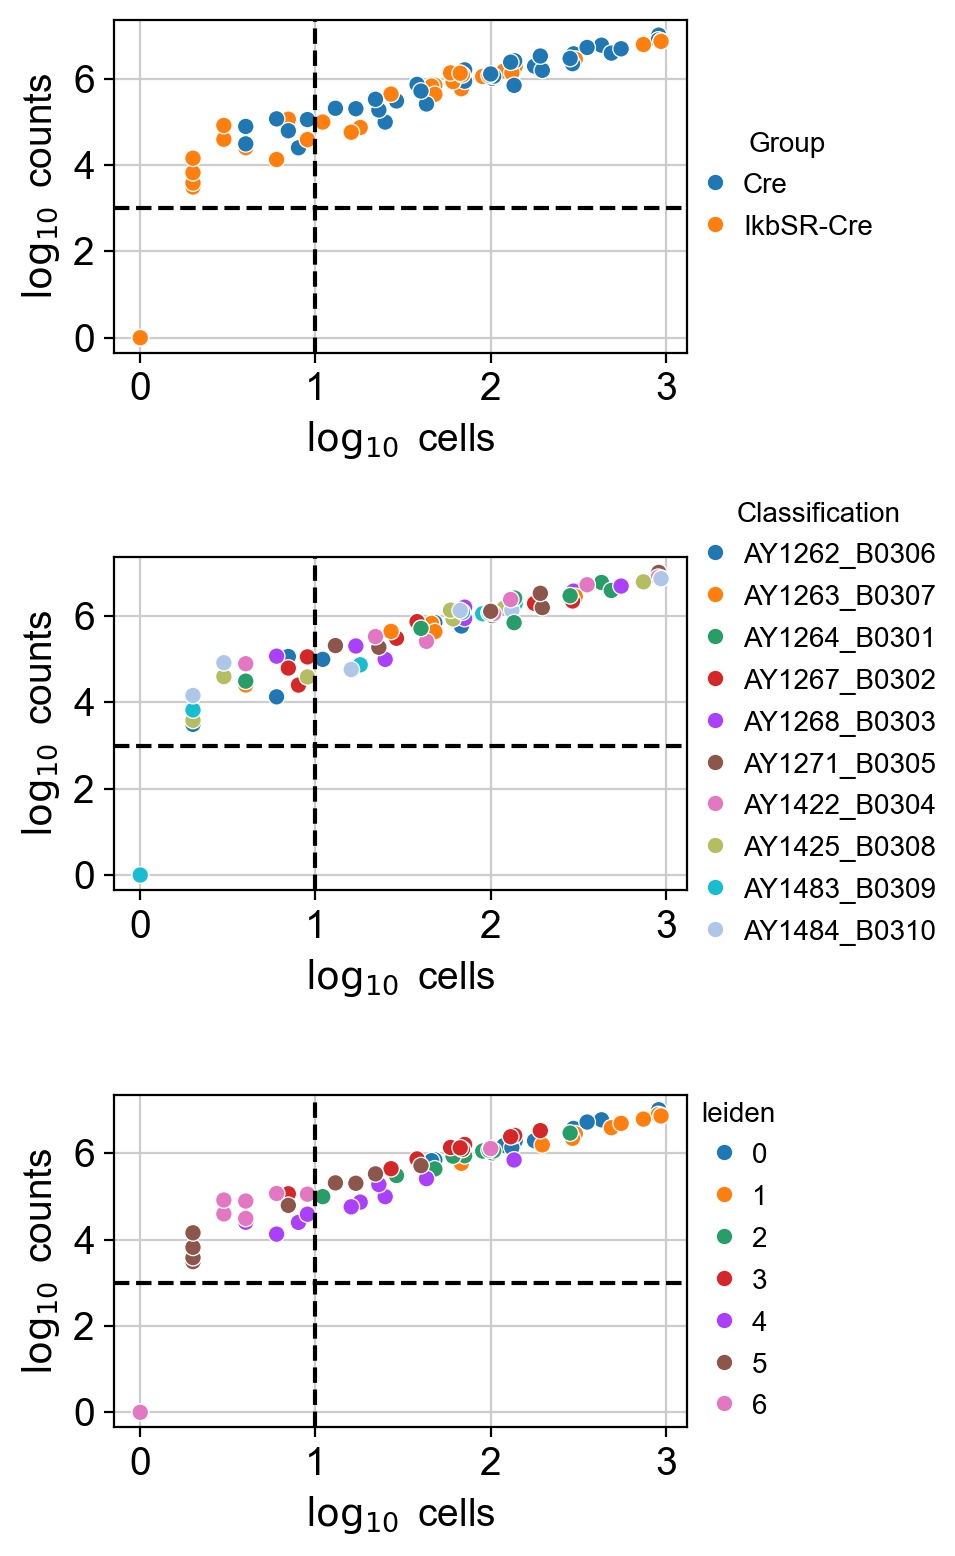

In [78]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["Group", "Classification",'leiden'], 
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

In [79]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

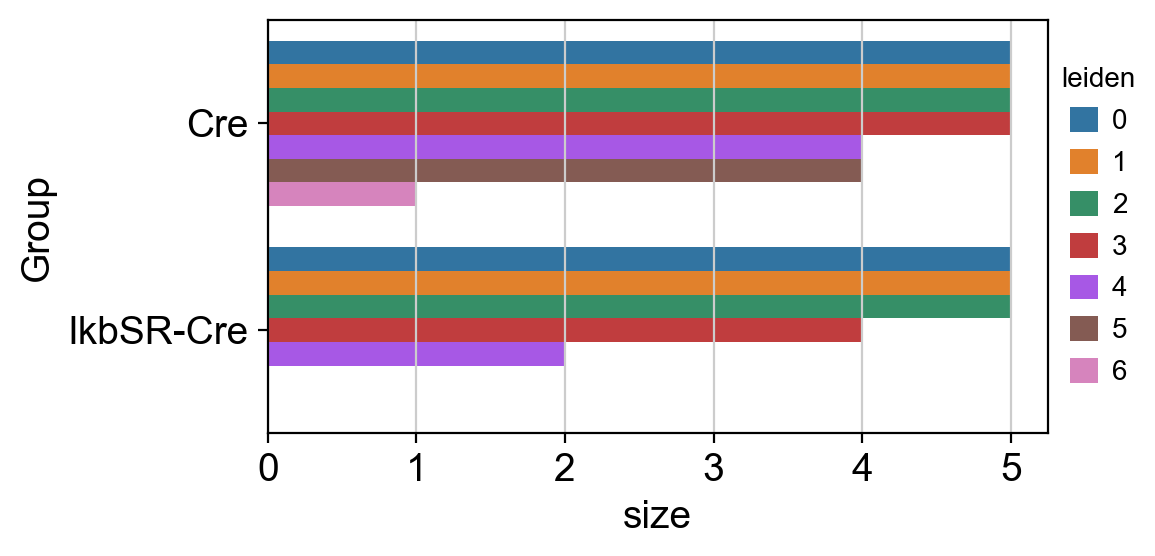

In [80]:
dc.pl.obsbar(adata=pdata, y="Group", hue="leiden", figsize=(6, 3)) 

In [81]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

pdatabak = pdata.copy()
for x in ['shRel', 'shRela', 'shRen', '2118-Nfkb1', '2117-Nfkb1', 'GFP_count', 'shRNA']:
    del pdata.obs[x]

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=49
    finished (0:00:00)


In [82]:
import numpy as np
import pandas as pd

print("obsm keys:", list(pdata.obsm.keys()))
print("X_pca shape:", None if "X_pca" not in pdata.obsm else pdata.obsm["X_pca"].shape)

print("\nobs columns:", pdata.obs.columns.tolist())
print("\nobs head:\n", pdata.obs.head())

# how many rows?
print("\nndata:", pdata.n_obs)

# Find candidate grouping columns: non-null and >1 unique value
candidates = []
for c in pdata.obs.columns:
    s = pdata.obs[c]
    nunq = s.dropna().nunique()
    if nunq >= 2:
        candidates.append((c, nunq, str(s.dtype)))
print("\nGrouping candidates (>=2 unique non-NA):")
print(pd.DataFrame(candidates, columns=["col","n_unique","dtype"]).sort_values("n_unique", ascending=False))


obsm keys: ['X_pca']
X_pca shape: (50, 49)

obs columns: ['Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts']

obs head:
                Classification leiden      Group      batch condition  \
AY1262_B0306_0   AY1262_B0306      0  IkbSR-Cre  IkbSR-Cre   perturb   
AY1263_B0307_0   AY1263_B0307      0  IkbSR-Cre  IkbSR-Cre   perturb   
AY1264_B0301_0   AY1264_B0301      0        Cre  IkbSR-Cre   control   
AY1267_B0302_0   AY1267_B0302      0        Cre  IkbSR-Cre   control   
AY1268_B0303_0   AY1268_B0303      0        Cre  IkbSR-Cre   control   

                psbulk_cells  psbulk_counts  
AY1262_B0306_0          47.0       711991.0  
AY1263_B0307_0          45.0       681620.0  
AY1264_B0301_0         428.0      6039710.0  
AY1267_B0302_0         177.0      1979563.0  
AY1268_B0303_0         296.0      3806926.0  

ndata: 50

Grouping candidates (>=2 unique non-NA):
              col  n_unique     dtype
5   psbulk_counts        50   float64


In [83]:
#dc.tl.rankby_obsm(pdata, key="X_pca")
dc.tl.rankby_obsm(pdata, key="X_pca", obs_keys=["Group", "condition"])

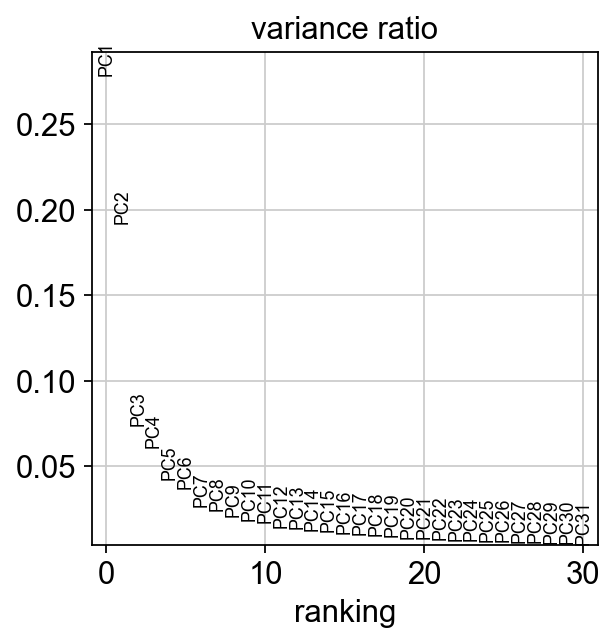

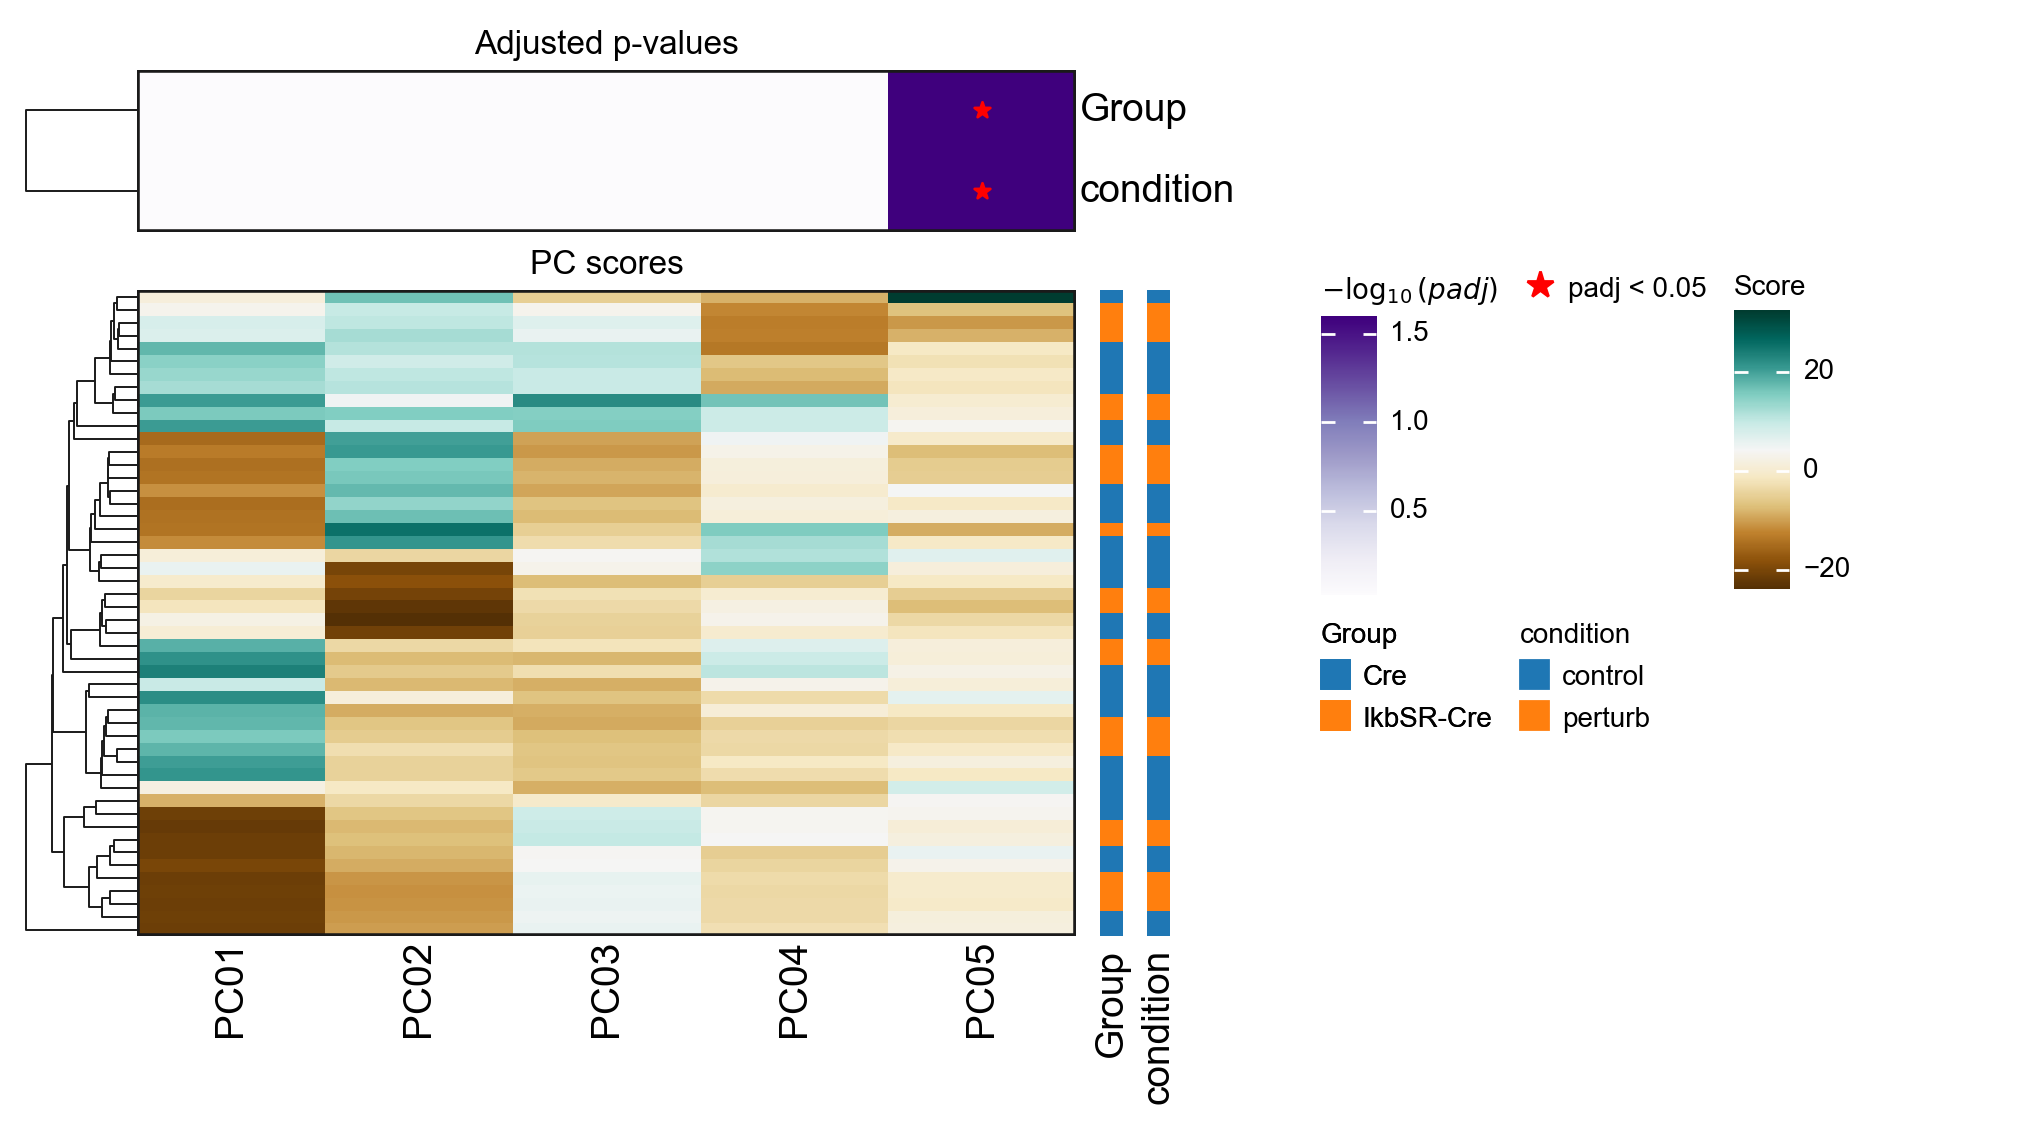

In [84]:
sc.pl.pca_variance_ratio(pdata)
dc.pl.obsm(adata=pdata, return_fig=True, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(10, 5))

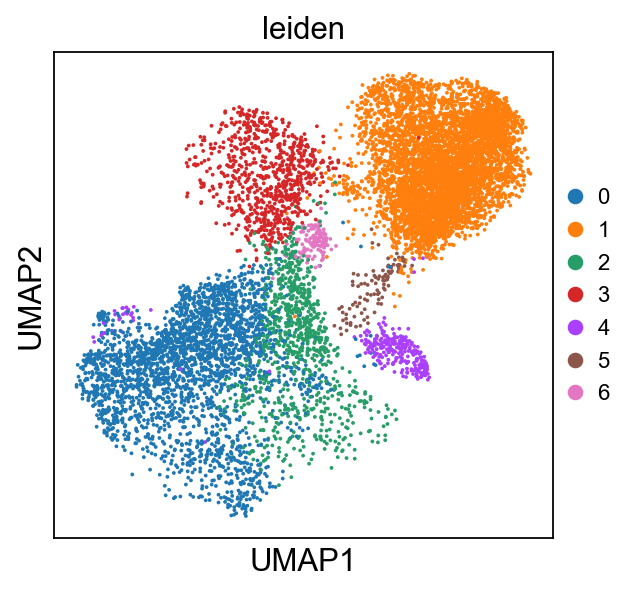

In [85]:
sc.pl.umap(adata, color='leiden')

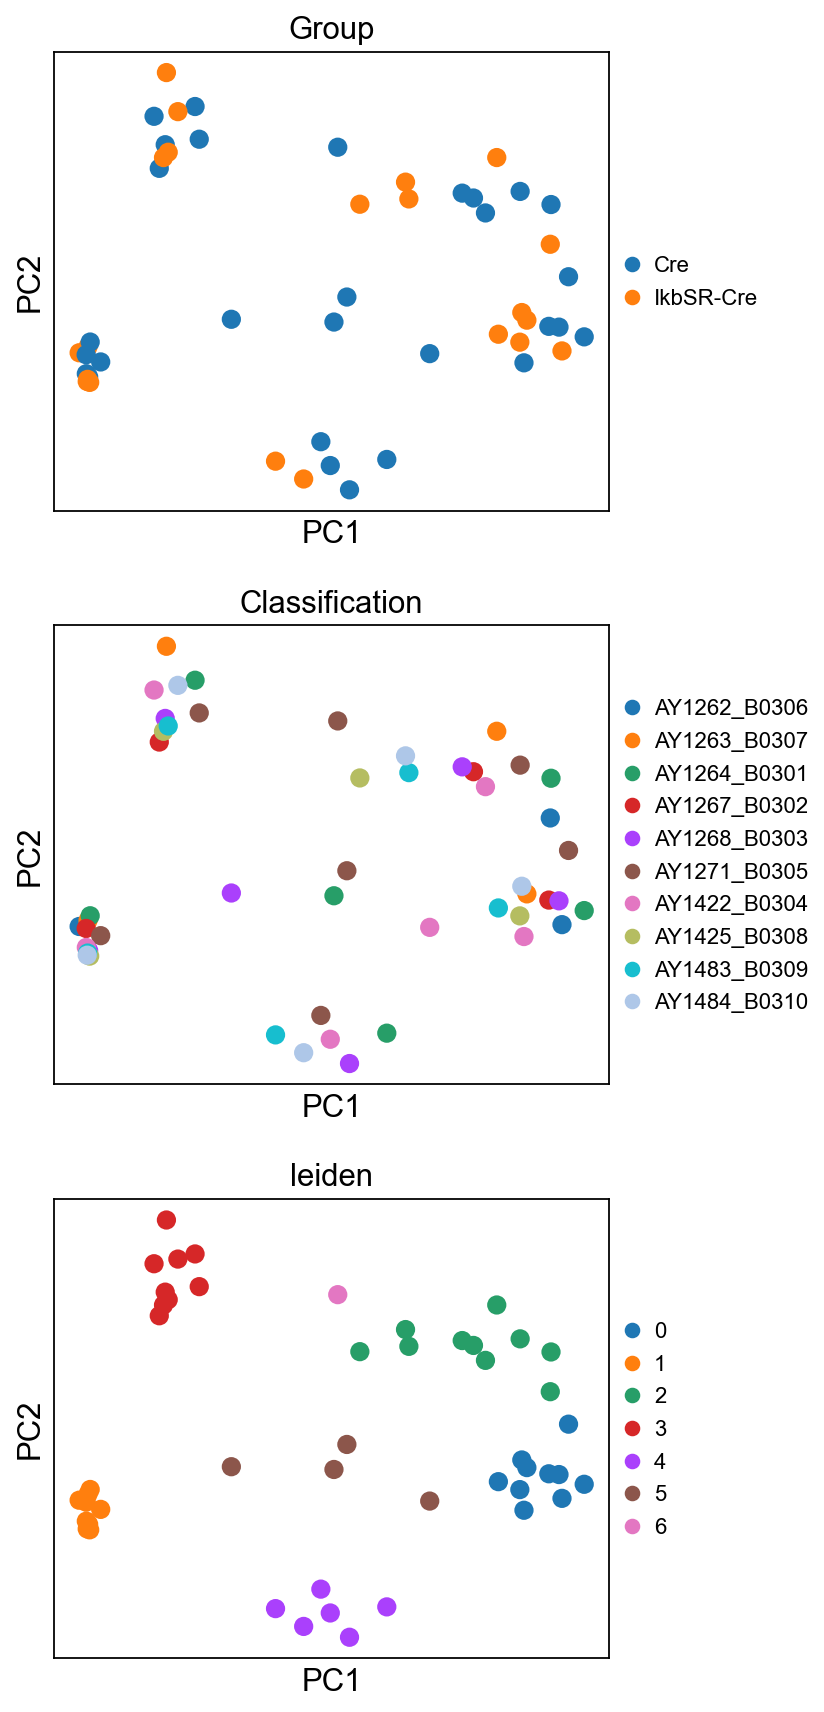

In [86]:
sc.pl.pca(
    pdata,
    color=["Group", "Classification",'leiden'], 
    ncols=1,
    size=300,
    frameon=True,
)

In [87]:
# select relevant samples
#hpcscells = pdata[pdata.obs["leiden"] == "3"].copy()
hpcscells = pdata.copy()
hpcscells

AnnData object with n_obs × n_vars = 50 × 30143
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane

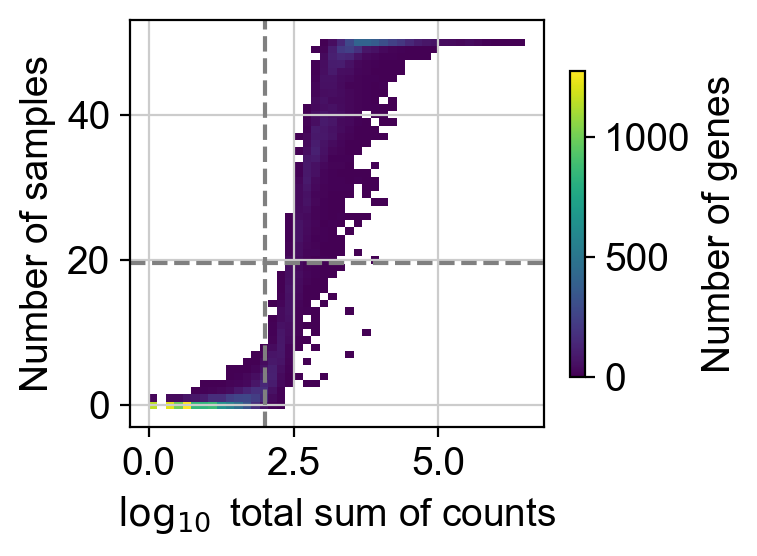

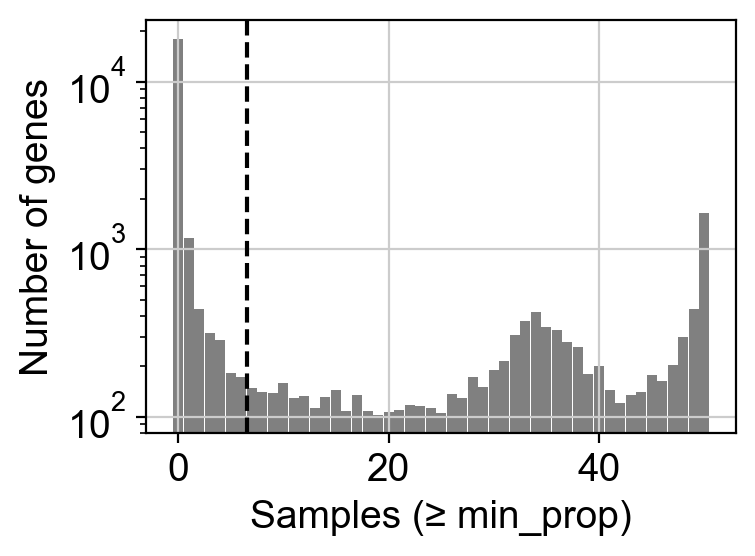

In [88]:
dc.pl.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=5, #10
    min_total_count=100, #15
    large_n=20,
    min_prop=0.1,
)
dc.pl.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=7, #2
)

In [89]:
dc.pp.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=5,
    min_total_count=100,
    large_n=20,
    min_prop=0.1,
)
dc.pp.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=7,
)
hpcscells

AnnData object with n_obs × n_vars = 50 × 9349
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane1

In [90]:
hpcscells.obs["Group"] = (
    hpcscells.obs["Group"]
    .astype("category")
    .cat.reorder_categories(
        ["Cre", "IkbSR-Cre"],
        ordered=True
    )
)


In [91]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=hpcscells,
    design_factors=["Group"],
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["Group", "IkbSR-Cre", "Cre"], inference=inference)

# Compute Wald test
stat_res.summary()

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_48357/429946494.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.10 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 4.64 seconds.

Fitting LFCs...
... done in 2.64 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 4 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Group IkbSR-Cre vs Cre
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Atxn7l1  15.022952        0.015421  0.149538  0.103127  0.917862  0.999784
Shkbp1   19.882738        0.301807  0.122469  2.464356  0.013726  0.723352
Frk      15.263461       -0.030133  0.212819 -0.141589  0.887405  0.999784
Oxsr1    24.252058        0.246873  0.243942  1.012017  0.311530  0.999784
Ltv1     26.402829       -0.226779  0.167749 -1.351894  0.176409  0.999784
...            ...             ...       ...       ...       ...       ...
Elmo3    14.545058       -0.141637  0.180400 -0.785127  0.432379  0.999784
Smim19   29.994547        0.014452  0.104228  0.138658  0.889720  0.999784
Rbm43    11.328842       -0.375650  0.253633 -1.481076  0.138586  0.999784
Sec22b   57.352953       -0.040663  0.115153 -0.353125  0.723995  0.999784
Riox2    17.444501        0.207717  0.144734  1.435169  0.151239  0.999784

[9349 rows x 6 columns]


... done in 0.75 seconds.



In [92]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Atxn7l1  15.022952        0.015421  0.149538  0.103127  0.917862  0.999784
Shkbp1   19.882738        0.301807  0.122469  2.464356  0.013726  0.723352
Frk      15.263461       -0.030133  0.212819 -0.141589  0.887405  0.999784
Oxsr1    24.252058        0.246873  0.243942  1.012017  0.311530  0.999784
Ltv1     26.402829       -0.226779  0.167749 -1.351894  0.176409  0.999784
...            ...             ...       ...       ...       ...       ...
Elmo3    14.545058       -0.141637  0.180400 -0.785127  0.432379  0.999784
Smim19   29.994547        0.014452  0.104228  0.138658  0.889720  0.999784
Rbm43    11.328842       -0.375650  0.253633 -1.481076  0.138586  0.999784
Sec22b   57.352953       -0.040663  0.115153 -0.353125  0.723995  0.999784
Riox2    17.444501        0.207717  0.144734  1.435169  0.151239  0.999784

[9349 rows x 6 columns]

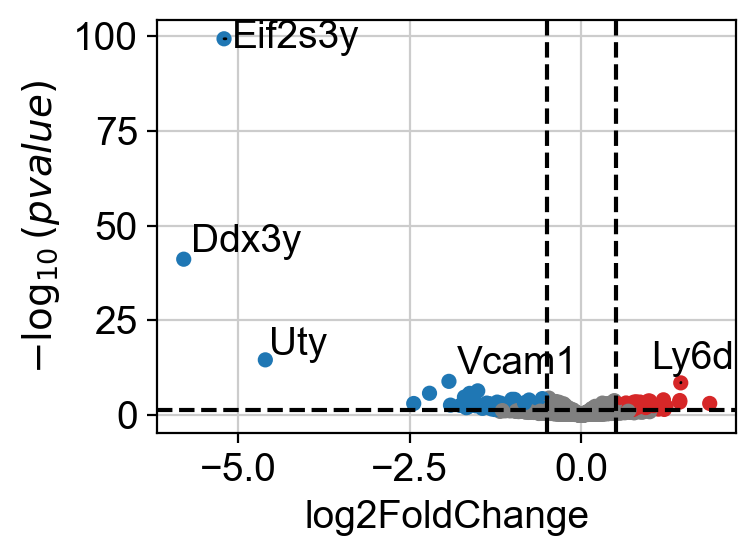

In [93]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

In [94]:
# check Nfkb1 expression
results_df.loc["Nfkb1", ["log2FoldChange", "pvalue", "padj"]]

log2FoldChange   -0.377478
pvalue            0.276349
padj              0.999784
Name: Nfkb1, dtype: float64

In [95]:
adata.obs.groupby(["Group", "Classification"]).size().unstack(fill_value=0)


Classification  AY1262_B0306  AY1263_B0307  AY1264_B0301  AY1267_B0302  \
Group                                                                    
Cre                        0             0          1511           555   
IkbSR-Cre                136           425             0             0   

Classification  AY1268_B0303  AY1271_B0305  AY1422_B0304  AY1425_B0308  \
Group                                                                    
Cre                     1035          1530          1555             0   
IkbSR-Cre                  0             0             0           990   

Classification  AY1483_B0309  AY1484_B0310  
Group                                       
Cre                        0             0  
IkbSR-Cre               1253          1249

In [96]:
import numpy as np, pandas as pd

x = adata.raw[:, "Nfkb1"].X.toarray().ravel()   # guaranteed length = n_obs
tmp = pd.DataFrame({
    "Group": adata.obs["Group"].to_numpy(),
    "Rep": adata.obs["Classification"].to_numpy(),  # mouse id
    "Nfkb1": x
})

rep_means = tmp.groupby(["Group","Rep"])["Nfkb1"].mean().reset_index()
rep_means

per_mouse = tmp.groupby(["Group","Rep"]).agg(
    mean=("Nfkb1","mean"),
    pct_detected=("Nfkb1", lambda v: (v>0).mean()),
    mean_detected=("Nfkb1", lambda v: v[v>0].mean() if (v>0).any() else np.nan),
    n_cells=("Nfkb1","size")
).reset_index()
per_mouse

Group           Rep      mean  pct_detected  mean_detected  n_cells
0        Cre  AY1264_B0301  0.167799      0.221707       0.756848     1511
1        Cre  AY1267_B0302  0.152819      0.196396       0.778116      555
2        Cre  AY1268_B0303  0.118590      0.177778       0.667071     1035
3        Cre  AY1271_B0305  0.255018      0.317647       0.802835     1530
4        Cre  AY1422_B0304  0.111002      0.162701       0.682246     1555
5  IkbSR-Cre  AY1262_B0306  0.137408      0.169118       0.812499      136
6  IkbSR-Cre  AY1263_B0307  0.094860      0.129412       0.733013      425
7  IkbSR-Cre  AY1425_B0308  0.059036      0.086869       0.679603      990
8  IkbSR-Cre  AY1483_B0309  0.055145      0.077414       0.712337     1253
9  IkbSR-Cre  AY1484_B0310  0.048104      0.072858       0.660235     1249

In [97]:
per_mouse.groupby("Group")[["mean","pct_detected","mean_detected"]].describe()


mean                                                              \
          count      mean       std       min       25%       50%       75%   
Group                                                                         
Cre         5.0  0.161046  0.057556  0.111002  0.118590  0.152819  0.167799   
IkbSR-Cre   5.0  0.078911  0.037367  0.048104  0.055145  0.059036  0.094860   

                    pct_detected            ...                      \
                max        count      mean  ...       75%       max   
Group                                       ...                       
Cre        0.255018          5.0  0.215246  ...  0.221707  0.317647   
IkbSR-Cre  0.137408          5.0  0.107134  ...  0.129412  0.169118   

          mean_detected                                                    \
                  count      mean       std       min       25%       50%   
Group                                                                       
Cre                 5.0  0.737423  0.059804  0.667071  0.682246  0.756848   
IkbSR-Cre           5.0  0.719537  0.059133  0.660235  0.679603  0.712337   

                               
                75%       max  
Group                          
Cre        0.778116  0.802835  
IkbSR-Cre  0.733013  0.812499  

[2 rows x 24 columns]

In [98]:
per_mouse.groupby("Group")["n_cells"].describe()


count    mean         std    min     25%     50%     75%     max
Group                                                                      
Cre          5.0  1237.2  438.171428  555.0  1035.0  1511.0  1530.0  1555.0
IkbSR-Cre    5.0   810.6  505.932110  136.0   425.0   990.0  1249.0  1253.0

In [99]:
rep_means.groupby("Group")["Nfkb1"].agg(["mean","std","count"])


mean       std  count
Group                               
Cre        0.161046  0.057556      5
IkbSR-Cre  0.078911  0.037367      5

In [100]:
import numpy as np
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

def _to_counts_df(adata_sub):
    """Return genes x samples integer counts dataframe from AnnData."""
    X = adata_sub.X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)
    # DESeq expects integers
    if not np.all(np.isfinite(X)):
        raise ValueError("Counts contain non-finite values.")
    # rounding only if you KNOW you have counts; otherwise stop
    if not np.all(np.mod(X, 1) == 0):
        raise ValueError("Counts are not integers. Ensure pdata.X is summed raw counts.")
    # pydeseq2 expects samples x genes as a DataFrame in many examples,
    # but DeseqDataSet(adata=...) accepts AnnData directly.
    return X

def run_deseq_by_leiden(
    pdata,
    leiden_col="leiden",
    group_col="Group",
    mouse_col="Classification",
    ref_group="Cre",
    contrast_group="IkbSR-Cre",
    gene_of_interest="Nfkb1",
    gene_set=None,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=None,  # set e.g. 50 if you have pdata.obs["n_cells"]
):
    rows = []
    gene_set = gene_set or []

    # optional cell-count filter
    ad = pdata
    if min_cells_per_pseudobulk is not None and "n_cells" in ad.obs.columns:
        ad = ad[ad.obs["n_cells"].astype(int) >= int(min_cells_per_pseudobulk)].copy()

    for k in sorted(ad.obs[leiden_col].unique(), key=lambda x: str(x)):
        sub = ad[ad.obs[leiden_col] == k].copy()

        # mice per group in this state
        mice_by_group = (
            sub.obs[[group_col, mouse_col]]
            .drop_duplicates()
            .groupby(group_col)[mouse_col]
            .nunique()
            .to_dict()
        )

        n_ref = int(mice_by_group.get(ref_group, 0))
        n_con = int(mice_by_group.get(contrast_group, 0))

        # skip underpowered states
        if n_ref < min_mice_per_group or n_con < min_mice_per_group:
            rows.append({
                "leiden": k,
                "status": "skipped_low_mice",
                "n_mice_ref": n_ref,
                "n_mice_contrast": n_con,
                "ref_group": ref_group,
                "contrast_group": contrast_group,
            })
            continue

        # sanity: counts integer?
        _ = _to_counts_df(sub)

        # run DESeq2 for this state
        dds = DeseqDataSet(
            adata=sub,
            design_factors=[group_col],
            refit_cooks=True,
        )
        dds.deseq2()

        stat = DeseqStats(
            dds,
            contrast=[group_col, contrast_group, ref_group],
        )
        stat.summary()
        res = stat.results_df.copy()  # index = genes

        # Pull gene of interest
        if gene_of_interest in res.index:
            goi = res.loc[gene_of_interest]
            goi_lfc = float(goi["log2FoldChange"])
            goi_p = float(goi["pvalue"])
            goi_padj = float(goi["padj"]) if pd.notnull(goi["padj"]) else np.nan
            goi_stat = float(goi["stat"])
        else:
            goi_lfc = goi_p = goi_padj = goi_stat = np.nan

        # Summarize NFkB gene set using DESeq2 stats (directional)
        gs = [g for g in gene_set if g in res.index]
        if len(gs) > 0:
            # Use mean(stat) as a stable directional summary; also record mean(log2FC)
            nfkb_stat_mean = float(np.nanmean(res.loc[gs, "stat"].values))
            nfkb_lfc_mean = float(np.nanmean(res.loc[gs, "log2FoldChange"].values))
            nfkb_n_genes = int(len(gs))
        else:
            nfkb_stat_mean = nfkb_lfc_mean = np.nan
            nfkb_n_genes = 0

        rows.append({
            "leiden": k,
            "status": "ok",
            "n_mice_ref": n_ref,
            "n_mice_contrast": n_con,
            "ref_group": ref_group,
            "contrast_group": contrast_group,
            "gene": gene_of_interest,
            "gene_log2FC": goi_lfc,
            "gene_stat": goi_stat,
            "gene_p": goi_p,
            "gene_padj": goi_padj,
            "nfkb_genes_used": nfkb_n_genes,
            "nfkb_stat_mean": nfkb_stat_mean,
            "nfkb_log2FC_mean": nfkb_lfc_mean,
        })

    out = pd.DataFrame(rows)

    # Nice ordering for reading
    out["leiden"] = out["leiden"].astype(str)
    out = out.sort_values(["status", "leiden"], ascending=[True, True]).reset_index(drop=True)
    return out


In [101]:
tidy_hp2 = run_deseq_by_leiden(
    pdata=pdata,
    ref_group="Cre",
    contrast_group="IkbSR-Cre",
    gene_of_interest="Nfkb1",
    gene_set=hallmark_nfkb,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=20,  # set None if you don't have n_cells or don't want filtering
)
tidy_hp2


/tmp/ipykernel_48357/2822294669.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 7.11 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 8.31 seconds.

Fitting LFCs...
... done in 6.68 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.56 seconds.

/tmp/ipykernel_48357/2822294669.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IkbSR-Cre vs Cre
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gm43260      8.846160        0.070838  0.400802  0.176741  0.859712  0.998543
Gm26873      0.800408       -0.328393  1.452253 -0.226126  0.821103  0.998543
Dhx8        31.814630        0.204921  0.239515  0.855568  0.392237  0.998543
BC035044     0.119700        2.628101  3.501451  0.750575  0.452908       NaN
AC166110.4   0.000000             NaN       NaN       NaN       NaN       NaN
...               ...             ...       ...       ...       ...       ...
Gm13180      0.000000             NaN       NaN       NaN       NaN       NaN
Gdpd3        0.874057       -1.338267  1.572628 -0.850975  0.394783  0.998543
Gm45924      0.000000             NaN       NaN       NaN       NaN       NaN
Iqcg         4.709358       -0.669587  0.634486 -1.055321  0.291279  0.998543
Serpinb1a    6.839030        0.023828  1.706957  0.013959  0.988862  0.999781

[3

Fitting dispersions...
... done in 5.49 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 6.62 seconds.

Fitting LFCs...
... done in 6.21 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.67 seconds.

/tmp/ipykernel_48357/2822294669.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IkbSR-Cre vs Cre
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gm43260      0.318930       -1.491575  3.402500 -0.438376  0.661114       NaN
Gm26873      0.000000             NaN       NaN       NaN       NaN       NaN
Dhx8         7.522822        0.012361  0.445102  0.027771  0.977845  0.999676
BC035044     0.045892       -0.544161  3.513405 -0.154881  0.876915       NaN
AC166110.4   0.150608        0.512658  2.922592  0.175412  0.860756       NaN
...               ...             ...       ...       ...       ...       ...
Gm13180      0.104717        1.057985  3.459159  0.305850  0.759719       NaN
Gdpd3        6.660873       -0.270639  0.572852 -0.472442  0.636611  0.999676
Gm45924      0.000000             NaN       NaN       NaN       NaN       NaN
Iqcg         5.579879       -0.909444  0.846498 -1.074360  0.282661  0.955134
Serpinb1a   10.220218       -1.058402  0.403731 -2.621553  0.008753  0.243701

[3

Fitting dispersions...
... done in 5.28 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 6.57 seconds.

Fitting LFCs...
... done in 6.49 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.66 seconds.

/tmp/ipykernel_48357/2822294669.py:74: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group IkbSR-Cre vs Cre
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gm43260      1.945377        0.715467  0.850265  0.841464  0.400088       NaN
Gm26873      0.187465        1.169292  2.626023  0.445271  0.656124       NaN
Dhx8        17.107395        0.579924  0.393564  1.473518  0.140611  0.998902
BC035044     0.000000             NaN       NaN       NaN       NaN       NaN
AC166110.4   0.000000             NaN       NaN       NaN       NaN       NaN
...               ...             ...       ...       ...       ...       ...
Gm13180      0.000000             NaN       NaN       NaN       NaN       NaN
Gdpd3        1.120990       -0.560232  1.025061 -0.546536  0.584698       NaN
Gm45924      0.000000             NaN       NaN       NaN       NaN       NaN
Iqcg         1.329222       -1.077539  1.204526 -0.894575  0.371015       NaN
Serpinb1a    3.654258       -3.429634  1.407968 -2.435876  0.014856  0.544093

[3

Fitting dispersions...
... done in 5.81 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 6.87 seconds.

Fitting LFCs...
... done in 5.62 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.72 seconds.



Log2 fold change & Wald test p-value: Group IkbSR-Cre vs Cre
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gm43260      2.261731        0.914372  0.889149  1.028367  0.303777       NaN
Gm26873      0.508719        0.132385  1.932708  0.068497  0.945390       NaN
Dhx8        30.053769        0.060545  0.250828  0.241380  0.809260  0.991219
BC035044     0.048779        0.290052  3.723582  0.077896  0.937911       NaN
AC166110.4   0.189030        1.011396  3.487947  0.289969  0.771840       NaN
...               ...             ...       ...       ...       ...       ...
Gm13180      0.310809       -1.255008  2.730539 -0.459619  0.645790       NaN
Gdpd3        6.315434        0.916126  0.582500  1.572748  0.115777  0.763442
Gm45924      0.000000             NaN       NaN       NaN       NaN       NaN
Iqcg         3.133935       -0.362747  0.972718 -0.372921  0.709207       NaN
Serpinb1a    0.872567       -1.780177  1.726318 -1.031199  0.302448       NaN

[3

leiden            status  n_mice_ref  n_mice_contrast ref_group  \
0      0                ok           5                5       Cre   
1      1                ok           5                5       Cre   
2      2                ok           5                5       Cre   
3      3                ok           5                4       Cre   
4      4  skipped_low_mice           4                2       Cre   
5      5  skipped_low_mice           4                0       Cre   
6      6  skipped_low_mice           1                0       Cre   

  contrast_group   gene  gene_log2FC  gene_stat    gene_p  gene_padj  \
0      IkbSR-Cre  Nfkb1    -0.201638  -1.225517  0.220380   0.998543   
1      IkbSR-Cre  Nfkb1    -0.716128  -1.609990  0.107400   0.767746   
2      IkbSR-Cre  Nfkb1    -0.725800  -2.472428  0.013420   0.516004   
3      IkbSR-Cre  Nfkb1    -0.861283  -3.405925  0.000659   0.036616   
4      IkbSR-Cre    NaN          NaN        NaN       NaN        NaN   
5      IkbSR-Cre    NaN          NaN        NaN       NaN        NaN   
6      IkbSR-Cre    NaN          NaN        NaN       NaN        NaN   

   nfkb_genes_used  nfkb_stat_mean  nfkb_log2FC_mean  
0            198.0       -0.778154         -0.182973  
1            198.0       -1.305640         -0.675157  
2            198.0       -0.667513         -0.328021  
3            198.0       -0.784317         -0.411889  
4              NaN             NaN               NaN  
5              NaN             NaN               NaN  
6              NaN             NaN               NaN

In [102]:
adata.n_obs, adata.raw.n_obs


(10239, 10239)

In [103]:
x = adata.raw[:, "Nfkb1"].X
type(x), x.shape


(scipy.sparse._csr.csr_matrix, (10239, 1))

In [104]:
adata.obs.shape[0], adata.X.shape[0]


(10239, 10239)

## Calculate phenotypic volume

In [105]:
#Phenotypic Volume
def calcPV(matrix):
    if hasattr(matrix, 'toarray'):
        matrix = matrix.toarray()
    
    matrix = np.asarray(matrix, dtype=np.float64)
    gene_cov = np.cov(matrix.T)
    mat = pd.DataFrame(gene_cov)
    eig_vals = np.linalg.eigvalsh(mat)
    return(sum(np.log2(eig_vals[eig_vals > 0])))

In [106]:
from scipy.stats import mannwhitneyu

In [107]:
repeats = 1000

In [108]:
adata.obs['Group'].value_counts()

Group
Cre          6186
IkbSR-Cre    4053
Name: count, dtype: int64

In [109]:
matrix = adata[adata.obs['Group'].isin(['Cre']),adata.var['highly_variable']].X.copy()
dist1 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist1.append(calcPV(matrix[sample_id]))

In [110]:
matrix = adata[adata.obs['Group'].isin(['IkbSR-Cre']),adata.var['highly_variable']].X.copy()
dist2 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist2.append(calcPV(matrix[sample_id]))

2026-02-04 17:03:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-04 17:03:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


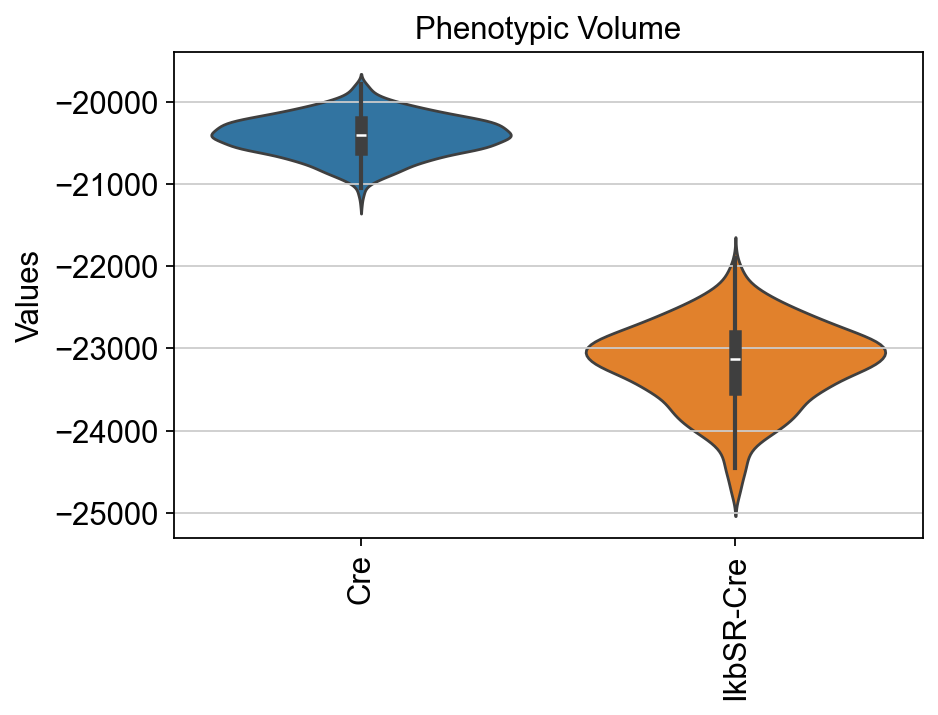

In [111]:
import seaborn as sns
data = [dist1, dist2]
labels = ["Cre", "IkbSR-Cre"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.show()

## Figures for the paper

### Look within whole tumor

2026-02-04 17:03:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-04 17:03:42 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


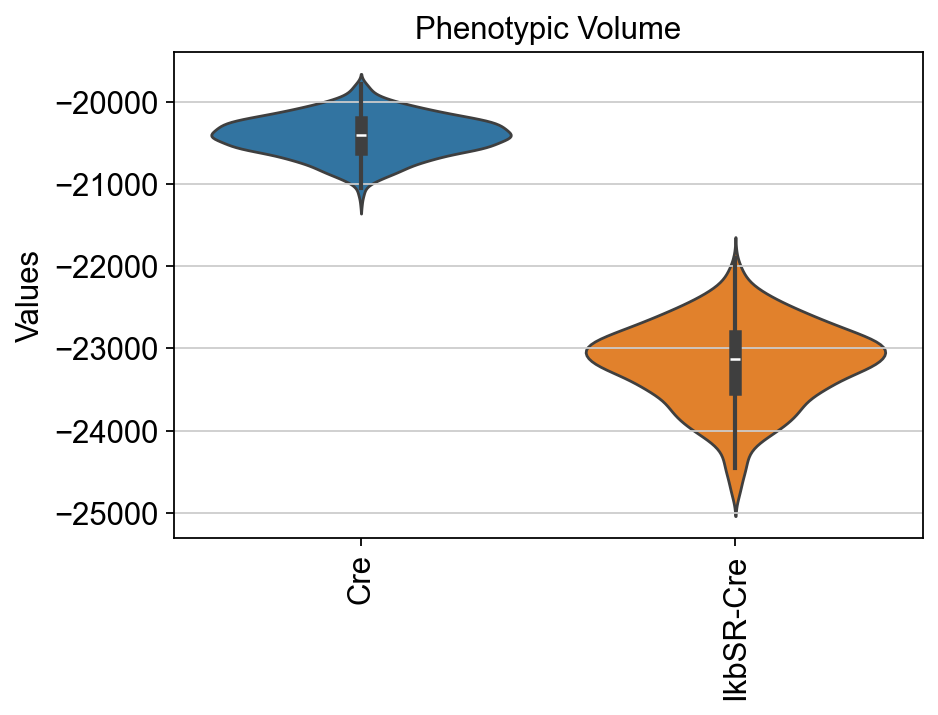

In [112]:
import seaborn as sns
data = [dist1, dist2]
labels = ["Cre", "IkbSR-Cre"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.savefig("figures/IkbSR_PV.svg")
plt.show()

In [113]:
pd.DataFrame(np.column_stack((dist1,dist2)),columns=['Cre','IkbSR-Cre']).to_excel('figures/IkbSR_PV.xlsx')

In [114]:
enr1a.res2d

Gene_set        Term  Overlap       P-value  Adjusted P-value  Odds Ratio  \
0   gs_ind_0   Cluster 1  192/240  5.626339e-28      3.375803e-27    4.960482   
1   gs_ind_0  Cluster 10  193/500  9.999404e-01      1.000000e+00    0.692831   
2   gs_ind_0  Cluster 11  114/500  1.000000e+00      1.000000e+00    0.299029   
3   gs_ind_0  Cluster 12  262/500  2.840700e-03      4.869772e-03    1.307721   
4   gs_ind_0   Cluster 2    67/82  3.638516e-11      1.091555e-10    5.153870   
5   gs_ind_0   Cluster 3  146/209  2.221712e-12      8.886849e-12    2.789377   
6   gs_ind_0   Cluster 4    43/63  3.686010e-04      7.372021e-04    2.473637   
7   gs_ind_0   Cluster 5  295/406  2.351585e-29      2.821902e-28    3.419041   
8   gs_ind_0   Cluster 6  257/500  1.105656e-02      1.658484e-02    1.249536   
9   gs_ind_0   Cluster 7   52/500  1.000000e+00      1.000000e+00    0.110371   
10  gs_ind_0   Cluster 8  226/391  1.683942e-06      4.041461e-06    1.650429   
11  gs_ind_0   Cluster 9   78/248  9.999998e-01      1.000000e+00    0.509504   

    Combined Score                                              Genes  
0     3.112450e+02  Ift20;Psmb8;Btg2;Nfkbia;Retnla;Epas1;Ifrd1;Gli...  
1     4.129116e-05  Mir22hg;Vamp2;Plxnb1;Zfyve21;Sptlc1;Clybl;Acsl...  
2    -0.000000e+00  Fblim1;Meis3;Slc30a4;Jag1;Ccs;Usp43;Gm26735;Ut...  
3     7.668087e+00  Lgmn;Fetub;Cenpb;Spopl;Commd2;Iars2;Ctsz;Tmem3...  
4     1.238829e+02  Atp11a;Npw;mt-Atp6;Secisbp2l;S100g;Yae1d1;Snx2...  
5     7.484664e+01  Dag1;Ptpn14;Agrn;Arhgap35;Dennd3;Bmpr2;Spats2l...  
6     1.955607e+01  Cebpa;Lcn2;Mylk;Kcnc3;H2-DMa;Xdh;Zfp467;Atp13a...  
7     2.253828e+02  Brd2;Actr2;Tnip3;Crtc2;Togaram1;Tjp2;Mob3a;Tcf...  
8     5.628825e+00  Trim12c;Nabp1;C130074G19Rik;Senp2;Ankrd37;Mlph...  
9    -0.000000e+00  Fzd2;Tfdp1;Topbp1;Sfmbt1;Dnmt1;Ckap5;Fbxo45;Dn...  
10    2.194142e+01  Tet2;Acss1;Gas6;Trmt1;Dpp4;Spaar;Gstt1;Cabin1;...  
11    1.190343e-07  Rpl19;Rpl27;Rps9;Gm10036;Rps12;Rpl10;Ftl1;Rps4...

In [115]:
#gseapy.barplot(enr0.res2d,title="%s IkbSR-Cre Up" % gsets)
gseapy.barplot(enr1a.res2d.sort_values("Adjusted P-value").head(5),title="%s IkbSR-Cre Down" % gsets,ofname='figures/Ext_Data_Fig2h_IkbSR-Cre_Clusters_Enrichr.svg')

### Look within the HPCS

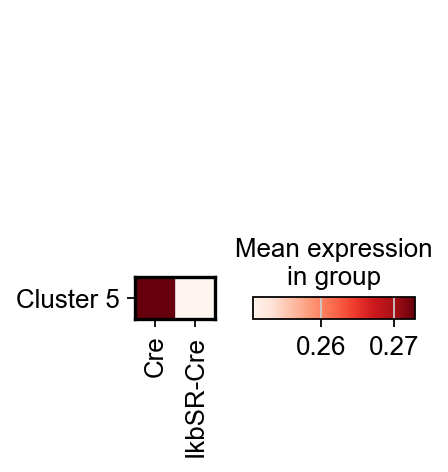

In [116]:
sc.pl.matrixplot(adata2, ['Cluster 5'], groupby='Group',cmap='Reds',swap_axes=True,save='Fig_1l_IkbSR.svg')

In [117]:
scipy.stats.ttest_ind(adata2[adata2.obs.Group.isin(['Cre']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['IkbSR-Cre']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(2.7310133167229416), pvalue=np.float64(0.006455655266785212), df=np.float64(785.0))

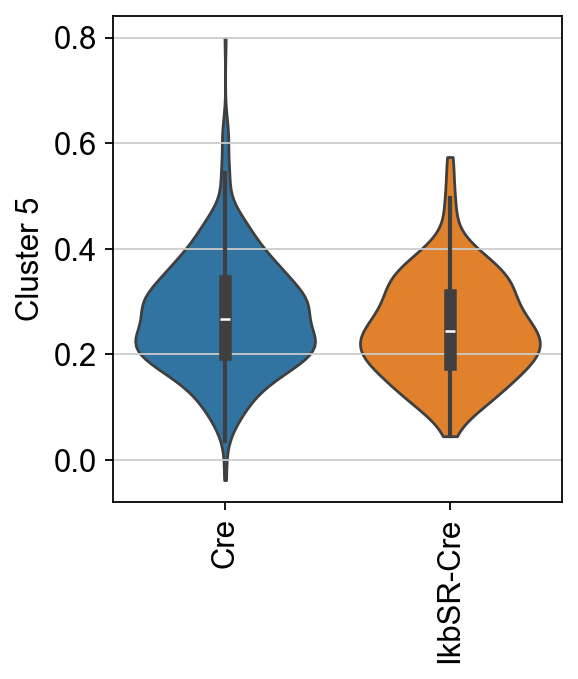

In [118]:
sc.pl.violin(adata2, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False, save='Ext_Data_Fig3e.svg')

In [119]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['Cre']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['IkbSR-Cre']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(70870.0), pvalue=np.float64(0.0066244386375118895))

In [120]:
#gseapy.barplot(enr1.res2d,title="%s IkbSR-Cre Down" % gsets,ofname='figures/Ext_Data_Fig2h.svg')
gseapy.dotplot(enr1.res2d,title="%s IkbSR-Cre Down" % gsets,cmap="RdBu_r",ofname='figures/Ext_Data_Fig2g_IkbSR-Cre_HallmarkDown_Enrichr.svg')